After our brilliant presentation about the Belgian Real Estate market, the companies asked us to create a Machine Learning model to predict prices on Belgium's real estate sales. We are hence working further on the same dataset that was previously scraped, preprocessed and analyzed. 

The steps that we'll follow are as follows:
- Step 1: Data cleaning
- Step 2: Data formatting
- Step 3: Model selection
- Step 4: Model training
- Step 5: Model evaluation 

Depending on the evaluation of the model, we'll repeat steps 1 tot 5 and hope to make our clients proud again. 

Let’s check whether the data has missing values.

Let’s define our feature matrix and the target vector. According to the problem definition, the feature matrix — X contains the values of Age and Height. The target vector — y contains the values Weight. Building a Regression Model is a supervised learning task so that we map the input X to the output y=f(X).

It is extremely useful to remove correlated variables in the feature matrix, X.— doing so will avoid misleading predictions

Having multicollinearity will lead to misleading predictions



https://towardsdatascience.com/polynomial-regression-with-a-machine-learning-pipeline-7e27d2dedc87

# Step 1 : Data Cleaning

We begin by importing the python packages and modules we will be using. Next we'll import our csv file as a dataframe and have a look how our dataframe looks like. 

In [582]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("data_set_immoweb.csv")
#We look at our dataframe 

df.head()



,Unnamed: 0.1,Locality,Type_of_property,Subtype_of_property,Price,Type_of_sale,Number_of_rooms,Living_Area,Fully_equipped_kitchen,Furnished,Open_fire,Terrace,Terrace_Area,Garden,Garden_Area,Surface_area_of_the_plot_of_land,Number_of_facades,Swimming_pool,State_of_the_building,Unnamed: 0
0,0,1130,APARTMENT,PENTHOUSE,450000.0,residential_sale,3.0,156.0,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN,0.0
1,1,1140,APARTMENT,PENTHOUSE,450000.0,residential_sale,3.0,156.0,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN,1.0
2,2,1140,APARTMENT,PENTHOUSE,450000.0,residential_sale,3.0,156.0,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN,2.0
3,3,1180,APARTMENT,APARTMENT,485000.0,residential_sale,2.0,107.0,USA_HYPER_EQUIPPED,False,False,True,17.0,NaN,NaN,NaN,NaN,False,AS_NEW,3.0
4,4,1000,APARTMENT,DUPLEX,460000.0,residential_sale,3.0,147.0,USA_HYPER_EQUIPPED,False,False,True,52.0,NaN,NaN,NaN,2.0,NaN,NaN,4.0


In [583]:
df.shape

(19372, 20)

We see there are already a few important steps to do

In [584]:
# Cleaning the dataset

#(1) Drop indices as Pandas creates indices too
df.drop('Unnamed: 0.1', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

#(2) Remove duplicates 
df.drop_duplicates(inplace=True)

#(3) No blank spaces. This method will delete the rows with ALL Nan values
df.dropna(how='all') 

#(4) Change the name of locality to Postal_code:
df.rename(columns={'Locality' :'Postal_code'},inplace=True)

#(5) Drop other columns which we won't use: 
remove_columns=['Swimming_pool','Number_of_facades', 'Terrace', 'Garden', 'Furnished']
df.drop(remove_columns, axis=1, inplace=True)





We analyse which other columns we can drop: 

In [585]:
df.shape

(17274, 13)

We want our model to predict house and apartment prices. We work as previously with only apartments and houses (Type of property). And only with residential sales (type of sale). The other type of sales include also entries of non-sale properties. 

In [586]:
#Dataset with only apartments and houses
df=df[df.Type_of_property.isin(['APARTMENT','HOUSE'])]

#Dataset with only residential sales
df=df[df.Type_of_sale=='residential_sale']

#Remove the Type_of_sale as it has only 1 value:
df=df.drop('Type_of_sale', axis=1)


In [541]:
df.shape

(16468, 13)

As we want to predict the prices we're only interested in the data which have price listings. We will remove the other rows without a price mentioned. 

In [587]:
df=df[(df.Price>100000) & (df.Price<2000000)]

df.dropna(subset=['Price'], inplace=True)

df['Price']=df['Price'].astype(int)


Let's have a further look on our dataset. We want to know how the unique values are, if there are missing values and how many missing values there are. This will give a better idea to see how we can preprocess the data. The following function will give this information

In [588]:
def analyze(dataframe):
    """
    This function shows all the columns of the dataframe.
    It prints the number of the unique values and also prints the unique values if it's less than 25. 
    Furthermore it shows you the number of missing values for each column and the column type. 
    """
    for i in dataframe.columns: 
        print(f"**************{i}**************") 
        if dataframe[i].nunique() <25:
            print(dataframe[i].unique())
        print("Number of unique values:",dataframe[i].nunique())
        print("Missing values:",dataframe[i].isnull().sum())
        print("Type:",dataframe[i].dtype)
        "\n"
        "\n"

In [589]:
analyze(df)

**************Postal_code**************
Number of unique values: 903
Missing values: 0
Type: int64
**************Type_of_property**************
['APARTMENT' 'HOUSE']
Number of unique values: 2
Missing values: 0
Type: object
**************Subtype_of_property**************
['PENTHOUSE' 'APARTMENT' 'DUPLEX' 'GROUND_FLOOR' 'FLAT_STUDIO' 'LOFT'
 'TRIPLEX' 'SERVICE_FLAT' 'KOT' 'HOUSE' 'APARTMENT_BLOCK' 'VILLA'
 'MANSION' 'MIXED_USE_BUILDING' 'EXCEPTIONAL_PROPERTY' 'COUNTRY_COTTAGE'
 'BUNGALOW' 'TOWN_HOUSE' 'FARMHOUSE' 'CHALET' 'CASTLE' 'OTHER_PROPERTY'
 'MANOR_HOUSE']
Number of unique values: 23
Missing values: 0
Type: object
**************Price**************
Number of unique values: 1515
Missing values: 0
Type: int32
**************Number_of_rooms**************
[ 3.  2.  1.  0.  4.  6.  5. 12.  7.  8.  9. 10. 16. 14. 17. 25. 11. 13.
 15. 19.]
Number of unique values: 20
Missing values: 0
Type: float64
**************Living_Area**************
Number of unique values: 606
Missing values: 787
Ty

We drop the missing values in Price. 

Based on the findings. We can see that we have categorical data and that there are missing values that we need to deal with. We can use dummies to make the values categorical but we will map it instead: 

In [590]:
#Using dictionnaries to map string values to numbers
df = df.replace({"Type_of_property":{"APARTMENT": 1, "HOUSE": 2}})
df = df.replace({"Subtype_of_property":{"PENTHOUSE": 1,"APARTMENT": 2, "DUPLEX": 3, "GROUND_FLOOR": 4, "FLAT_STUDIO": 5,"LOFT": 6, "TRIPLEX": 7, "SERVICE_FLAT": 8, "APARTMENT_GROUP": 9, "KOT": 10, "HOUSE": 11, "HOUSE_GROUP": 12, "APARTMENT_BLOCK": 13, "VILLA": 14, "MANSION": 15, "MIXED_USE_BUILDING": 16, "EXCEPTIONAL_PROPERTY": 17, "COUNTRY_COTTAGE": 18, "BUNGALOW": 19, "TOWN_HOUSE": 20, "FARMHOUSE": 21, "CHALET": 22, "CASTLE": 23, "OTHER_PROPERTY": 24, "MANOR_HOUSE": 25}})
df = df.replace({"Fully_equipped_kitchen":{"NOT_INSTALLED": 0, "USA_HYPER_EQUIPPED": 1, "INSTALLED": 2, "HYPER_EQUIPPED": 3, "SEMI_EQUIPPED": 4, "USA_INSTALLED": 5, "USA_SEMI_EQUIPPED": 6, "USA_UNINSTALLED": 7}})
df = df.replace({"State_of_the_building":{"AS_NEW": 1, "JUST_RENOVATED": 2, "TO_RESTORE": 3, "GOOD": 4, "TO_RENOVATE": 5, "TO_BE_DONE_UP": 6}})

Step 2: Preprocessing

In this step we'll deal with missing values. We'll check the type of the columns and see if we'll adjust or add any columns. 

In [591]:
#List of missing values in any column
missing_columns = df.columns[df.isna().any()].tolist()

print(missing_columns)

['Living_Area', 'Fully_equipped_kitchen', 'Terrace_Area', 'Garden_Area', 'Surface_area_of_the_plot_of_land', 'State_of_the_building']


We start with Living_Area. As there's a little correlation between Living_Area and Number_of_rooms we can use the latter to predict the Living_Area. We first want to remove the outliers by considering only apartments with less than 7 rooms and houses with less than 12 rooms. 

In [592]:
df.shape

(15824, 12)

We will consider only properties with less than 10 rooms. 

In [593]:
df['Number_of_rooms']= df['Number_of_rooms'].astype(int)
df=df[df.Number_of_rooms<11]

In [594]:
df.shape

(15785, 12)

In [595]:
#Change missing value in Living_Area by corresponding mean area depending to the type of property and number_of_rooms.
df['Living_Area'] = df['Living_Area'].fillna(df.groupby(['Type_of_property','Number_of_rooms'])['Living_Area'].transform('mean'))
df['Living_Area']=df['Living_Area'].astype(int)

In [596]:
df.isnull().sum()

Postal_code                             0
Type_of_property                        0
Subtype_of_property                     0
Price                                   0
Number_of_rooms                         0
Living_Area                             0
Fully_equipped_kitchen               3928
Open_fire                               0
Terrace_Area                         8651
Garden_Area                         11816
Surface_area_of_the_plot_of_land     7097
State_of_the_building                3055
dtype: int64

We will also preprocess the fully equipped kitchen. 

In [597]:
df['Fully_equipped_kitchen'].fillna(0, inplace=True)
df['Fully_equipped_kitchen']=df['Fully_equipped_kitchen'].astype(int)
df['Fully_equipped_kitchen'] = df['Fully_equipped_kitchen'].apply(lambda x : "False" if x in [0,7] else "True")



In [598]:
df = df.replace({"Fully_equipped_kitchen": {"False": 0, "True": 1}})
df['Fully_equipped_kitchen']= df['Fully_equipped_kitchen'].astype(int)

In [599]:
df.Fully_equipped_kitchen.value_counts()

1    11161
0     4624
Name: Fully_equipped_kitchen, dtype: int64

Next we'll replace the missing values for Furnished, Terrace, Terrace_Area, Garden, Surface_area_of_the_plot_of_land

In [600]:
df.dtypes

Postal_code                           int64
Type_of_property                      int64
Subtype_of_property                   int64
Price                                 int32
Number_of_rooms                       int32
Living_Area                           int32
Fully_equipped_kitchen                int32
Open_fire                              bool
Terrace_Area                        float64
Garden_Area                         float64
Surface_area_of_the_plot_of_land    float64
State_of_the_building               float64
dtype: object

In [601]:
df['Terrace_Area'].fillna(0, inplace=True)
df['Terrace_Area']=df['Terrace_Area'].astype(int)

In [602]:
df['State_of_the_building'].fillna("GOOD", inplace=True)
df = df.replace({"State_of_the_building":{"AS_NEW": 1, "JUST_RENOVATED": 2, "TO_RESTORE": 3, "GOOD": 4, "TO_RENOVATE": 5, "TO_BE_DONE_UP": 6}})
df['State_of_the_building']=df['State_of_the_building'].astype(int)

In [603]:
df['Surface_area_of_the_plot_of_land'].fillna(0, inplace=True)
df['Surface_area_of_the_plot_of_land']=df['Surface_area_of_the_plot_of_land'].astype(int)

In [604]:
df['Garden_Area'].fillna(0, inplace=True)
df['Garden_Area']=df['Garden_Area'].astype(int)

In [605]:
df.isnull().sum()

Postal_code                         0
Type_of_property                    0
Subtype_of_property                 0
Price                               0
Number_of_rooms                     0
Living_Area                         0
Fully_equipped_kitchen              0
Open_fire                           0
Terrace_Area                        0
Garden_Area                         0
Surface_area_of_the_plot_of_land    0
State_of_the_building               0
dtype: int64

We will narrow down our features depending on correlation and additional tests. We saw earlier in data visualization that 'Living_Area', 'Postal_code', 'Surface_area_of_the_plot_of_land', 'Number_of_rooms', 'Type_of_property' and 'Subtype_of_property' were important factors. Furthermore we will use a statistical test to see if there's also a relation with categorical values such as 'State_of_the_building' and  'Fully_equipped_kitchen'

In [606]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['Fully_equipped_kitchen'], df['Price'])

# Calculate the chi-squared test for independence
stat, p, dof, expected = chi2_contingency(contingency_table, correction=False)

#print p-value
print(p)

1.532307847394391e-08


The p-value is very small (<0.05) and says that the probability of this distribution in case of no association between the two variables is almost 0. This is hence a feature we would like to keep. 

As a last process in step 2 (preprocessing) we will add a column with 10 provinces of Belgium and the region Brussels. This can be needed for further analysis later. 

In [607]:
#Function to convert postal code to the 10 provinces or Brussels 
def provinces(postal_code):
    if 1000 <= postal_code < 1300:
        return "Brussels"
    elif 1300 <= postal_code < 1500:
        return "Walloon Brabant"
    elif (postal_code >= 1500 and postal_code < 2000) or (postal_code >= 3000 and postal_code < 3500):
        return "Flemish Brabant"
    elif 2000 <= postal_code < 3000:
        return "Antwerp"
    elif 3500 <= postal_code < 4000:
        return "Limburg"
    elif 4000 <= postal_code < 5000:
        return "Liège"
    elif 5000 <= postal_code < 6000:
        return "Namur"
    elif (postal_code >= 6000 and postal_code < 6600) or (postal_code >= 7000 and postal_code < 8000):
        return "Hainaut" 
    elif 6600 <= postal_code < 7000:
        return "Luxembourg"
    elif 8000 <= postal_code < 9000:
        return "West Flanders"  
    else: 
        return "East Flanders"

#add column next to postalcode
df.insert(1, 'Province', df.Postal_code.apply(provinces))

In [608]:
df.head(10)

,Postal_code,Province,Type_of_property,Subtype_of_property,Price,Number_of_rooms,Living_Area,Fully_equipped_kitchen,Open_fire,Terrace_Area,Garden_Area,Surface_area_of_the_plot_of_land,State_of_the_building
0,1130,Brussels,1,1,450000,3,156,1,False,43,0,0,4
1,1140,Brussels,1,1,450000,3,156,1,False,43,0,0,4
3,1180,Brussels,1,2,485000,2,107,1,False,17,0,0,1
4,1000,Brussels,1,3,460000,3,147,1,False,52,0,0,4
5,1340,Walloon Brabant,1,2,475000,3,115,0,False,20,0,0,1
6,1090,Brussels,1,4,499000,3,115,1,False,15,82,0,1
7,1180,Brussels,1,2,555000,2,95,1,False,11,0,0,1
8,1030,Brussels,1,2,557600,2,136,1,False,0,0,0,1
9,1000,Brussels,1,2,585000,2,131,1,False,46,58,0,1
10,1000,Brussels,1,2,595000,1,99,0,False,9,0,0,4


In [609]:
df=df.drop('Open_fire', axis=1)

In [610]:
df.shape

(15785, 12)

In [612]:
analyze(df)

**************Postal_code**************
Number of unique values: 901
Missing values: 0
Type: int64
**************Province**************
['Brussels' 'Walloon Brabant' 'West Flanders' 'East Flanders' 'Liège'
 'Hainaut' 'Luxembourg' 'Flemish Brabant' 'Namur' 'Antwerp' 'Limburg']
Number of unique values: 11
Missing values: 0
Type: object
**************Type_of_property**************
[1 2]
Number of unique values: 2
Missing values: 0
Type: int64
**************Subtype_of_property**************
[ 1  2  3  4  5  6  7  8 10 11 13 14 15 16 17 18 19 20 21 22 24 25 23]
Number of unique values: 23
Missing values: 0
Type: int64
**************Price**************
Number of unique values: 1513
Missing values: 0
Type: int32
**************Number_of_rooms**************
[ 3  2  1  0  4  6  5  7  8  9 10]
Number of unique values: 11
Missing values: 0
Type: int32
**************Living_Area**************
Number of unique values: 596
Missing values: 0
Type: int32
**************Fully_equipped_kitchen*************

We have no missing values and the dataset seems clean. We'll save everything in a csv and use it in our next part 

In [611]:
df.to_csv("cleaned_data_set_immoweb.csv")

We are going to split the dataframe into house and apartments. 

In [177]:
df_ap=df[df.Type_of_property=='APARTMENT']
df_house=df[df.Type_of_property=='HOUSE']

In [168]:
df_ap.head()

,Province,Type_of_property,Price,Number_of_rooms,Living_Area,Fully_equipped_kitchen,Furnished,Open_fire,Terrace,Terrace_Area,Garden,Garden_Area,Surface_area_of_the_plot_of_land,Number_of_facades,Swimming_pool,State_of_the_building
0,Brussels,APARTMENT,450000.0,3.0,156.0,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN
1,Brussels,APARTMENT,450000.0,3.0,156.0,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN
3,Brussels,APARTMENT,485000.0,2.0,107.0,USA_HYPER_EQUIPPED,False,False,True,17.0,NaN,NaN,NaN,NaN,False,AS_NEW
4,Brussels,APARTMENT,460000.0,3.0,147.0,USA_HYPER_EQUIPPED,False,False,True,52.0,NaN,NaN,NaN,2.0,NaN,NaN
5,Walloon Brabant,APARTMENT,475000.0,3.0,115.0,NOT_INSTALLED,False,False,True,20.0,NaN,NaN,NaN,NaN,NaN,AS_NEW


In [194]:
# TRY SOMETHING LIKE df_ap['Living_Area'] = df_ap.groupby('Number_of_rooms').transform(lambda group: group.fillna(group.mean()))


C:\Users\nacit\AppData\Local\Temp\ipykernel_24544\2216416278.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  df_ap['Living_Area'] = df_ap.groupby('Number_of_rooms').transform(lambda group: group.fillna(group.mean()))
C:\Users\nacit\AppData\Local\Temp\ipykernel_24544\2216416278.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  df_ap['Living_Area'] = df_ap.groupby('Number_of_rooms').transform(lambda group: group.fillna(group.mean()))
C:\Users\nacit\AppData\Local\Temp\ipykernel_24544\2216416278.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Bef

ValueError: Columns must be same length as key

Further analysis on apartments. We saw earlier that there's a high correlation between number_of_rooms and living area. We can hence change the missing values for living area by the mean value of living area depending on number of rooms. 

First change AP VALUE by 0 then by mean? 

In [132]:
df_ap.Number_of_rooms.value_counts()

2.0     3538
1.0     1437
3.0     1426
4.0      159
0.0      155
5.0       38
6.0       16
7.0        3
8.0        3
10.0       3
9.0        2
15.0       1
Name: Number_of_rooms, dtype: int64

As we have not enough values of apartments with number of rooms exceeding 6, our model will mainly be valid for apartments till 6 rooms. 

In [178]:
df_ap=df_ap[df_ap.Number_of_rooms<7]

In [179]:
df_ap.Number_of_rooms.value_counts()

2    3538
1    1437
3    1426
4     159
0     155
5      38
6      16
Name: Number_of_rooms, dtype: int64

In [107]:
df_ap.Number_of_rooms.unique()

array([3., 2., 1., 0., 4., 6., 5.])

In [182]:
df_ap['Living_Area'] = df['Living_Area'].fillna(df['Living_Area'].mean())
# df_ap['Living_Area'].fillna(lambda row: 55 if row['Number_of_rooms'] == 0 else 66 if row['Number_of_rooms'] == 1 else 104 if row['Number_of_rooms'] == 2 else 140 if row['Number_of_rooms'] == 3 else 190 if row['Number_of_rooms'] == 4 else 260,inplace=True)


In [183]:
df_ap.head(50)

,Province,Type_of_property,Price,Number_of_rooms,Living_Area,Fully_equipped_kitchen,Furnished,Open_fire,Terrace,Terrace_Area,Garden,Garden_Area,Surface_area_of_the_plot_of_land,Number_of_facades,Swimming_pool,State_of_the_building
0,Brussels,APARTMENT,450000,3,156.000000,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN
1,Brussels,APARTMENT,450000,3,156.000000,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN
3,Brussels,APARTMENT,485000,2,107.000000,USA_HYPER_EQUIPPED,False,False,True,17.0,NaN,NaN,NaN,NaN,False,AS_NEW
4,Brussels,APARTMENT,460000,3,147.000000,USA_HYPER_EQUIPPED,False,False,True,52.0,NaN,NaN,NaN,2.0,NaN,NaN
5,Walloon Brabant,APARTMENT,475000,3,115.000000,NOT_INSTALLED,False,False,True,20.0,NaN,NaN,NaN,NaN,NaN,AS_NEW
6,Brussels,APARTMENT,499000,3,115.000000,USA_HYPER_EQUIPPED,False,False,True,15.0,True,82.0,NaN,3.0,False,AS_NEW
7,Brussels,APARTMENT,555000,2,95.000000,USA_HYPER_EQUIPPED,False,False,True,11.0,NaN,NaN,NaN,2.0,False,AS_NEW
8,Brussels,APARTMENT,557600,2,136.000000,USA_HYPER_EQUIPPED,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,AS_NEW
9,Brussels,APARTMENT,585000,2,131.000000,USA_HYPER_EQUIPPED,NaN,False,True,46.0,True,58.0,NaN,2.0,False,AS_NEW
10,Brussels,APARTMENT,595000,1,99.000000,NaN,False,False,True,9.0,NaN,NaN,NaN,2.0,NaN,NaN


In [171]:
df_ap['Living_Area'] = pd.to_numeric(df_ap['Living_Area'])

TypeError: Invalid object type at position 46

In [184]:
df_ap.dtypes

Province                             object
Type_of_property                     object
Price                                 int32
Number_of_rooms                       int32
Living_Area                         float64
Fully_equipped_kitchen               object
Furnished                            object
Open_fire                              bool
Terrace                              object
Terrace_Area                        float64
Garden                               object
Garden_Area                         float64
Surface_area_of_the_plot_of_land    float64
Number_of_facades                   float64
Swimming_pool                        object
State_of_the_building                object
dtype: object

In [197]:
df_ap.head()

,Province,Type_of_property,Price,Number_of_rooms,Living_Area,Fully_equipped_kitchen,Furnished,Open_fire,Terrace,Terrace_Area,Garden,Garden_Area,Surface_area_of_the_plot_of_land,Number_of_facades,Swimming_pool,State_of_the_building
0,Brussels,APARTMENT,450000.0,3.0,156.0,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN
1,Brussels,APARTMENT,450000.0,3.0,156.0,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN
3,Brussels,APARTMENT,485000.0,2.0,107.0,USA_HYPER_EQUIPPED,False,False,True,17.0,NaN,NaN,NaN,NaN,False,AS_NEW
4,Brussels,APARTMENT,460000.0,3.0,147.0,USA_HYPER_EQUIPPED,False,False,True,52.0,NaN,NaN,NaN,2.0,NaN,NaN
5,Walloon Brabant,APARTMENT,475000.0,3.0,115.0,NOT_INSTALLED,False,False,True,20.0,NaN,NaN,NaN,NaN,NaN,AS_NEW


In [198]:
df_ap.isnull().sum()

Province                               0
Type_of_property                       0
Price                                  0
Number_of_rooms                        0
Living_Area                            0
Fully_equipped_kitchen              1934
Furnished                           1684
Open_fire                              0
Terrace                             1910
Terrace_Area                        3046
Garden                              5735
Garden_Area                         6228
Surface_area_of_the_plot_of_land    6781
Number_of_facades                   2652
Swimming_pool                       2861
State_of_the_building               1907
dtype: int64

We will repeat this process for a house: 

In [95]:
df_house.Number_of_rooms.value_counts()

3.0     3363
4.0     2128
2.0     1116
5.0      893
6.0      321
7.0      109
1.0      105
0.0       65
8.0       49
9.0       36
10.0      22
12.0       6
16.0       4
15.0       3
13.0       2
14.0       1
17.0       1
Name: Number_of_rooms, dtype: int64

As we have not enough values of apartments with number of rooms exceeding 10, our model will mainly be valid for houses from 1 till 10 rooms. 

In [26]:
df_house=df_house[(df_house.Number_of_rooms > 0) & (df_house.Number_of_rooms<11)]

In [111]:
df_house.groupby('Number_of_rooms').mean()


#df["Living_Area"] = df.apply(lambda row: 57 if row["Number_of_rooms"] == 0 else 66 if row["Number_of_rooms"] == 1 else 104 if row["Number_of_rooms"] == 2 else 140 if row["Number_of_rooms"] == 3 else 190 if row["Number_of_rooms"] == 4 else 260 , axis=1)

C:\Users\nacit\AppData\Local\Temp\ipykernel_24544\2020981470.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_house.groupby('Number_of_rooms').mean()


,Price,Living_Area,Open_fire,Terrace_Area,Garden_Area,Surface_area_of_the_plot_of_land,Number_of_facades
Number_of_rooms,,,,,,,
1.0,258818.095238,131.292929,0.038095,25.588235,377.714286,580.409524,2.662500
2.0,263890.114695,136.642105,0.034050,26.362500,367.009709,492.795699,2.748466
3.0,348520.343443,175.122577,0.055010,34.943980,476.659922,695.140946,2.952331
4.0,424084.983083,220.307540,0.092105,37.226994,647.884174,871.314380,3.010858
5.0,492406.255319,274.521338,0.083987,36.843195,699.500000,1128.194849,3.008974
6.0,550531.573209,328.737705,0.140187,44.575758,929.426573,1358.249221,2.975439
7.0,565807.339450,371.510204,0.091743,30.142857,616.096154,1286.697248,2.780000
8.0,635505.102041,421.369565,0.102041,46.222222,1407.866667,1962.040816,2.975000
9.0,593858.333333,434.718750,0.000000,44.444444,6781.375000,2285.305556,2.937500


In [27]:
df_house['Living_Area'].fillna(lambda row: 131 if row['Number_of_rooms'] == 1 else 136 if row['Number_of_rooms'] == 2 else 175 if row['Number_of_rooms'] == 3 else 220 if row['Number_of_rooms'] == 4 else 274 if row['Number_of_rooms'] == 5 else 328 if row['Number_of_rooms'] == 6 else 371 if row['Number_of_rooms'] == 7 else 421 if row['Number_of_rooms'] == 8 else 434 if row['Number_of_rooms'] == 9 else 570, inplace=True)

In [200]:
df_house.isnull().sum()

Province                               0
Type_of_property                       0
Price                                  0
Number_of_rooms                        0
Living_Area                            0
Fully_equipped_kitchen              1850
Furnished                           1343
Open_fire                              0
Terrace                             2888
Terrace_Area                        5212
Garden                              3486
Garden_Area                         5024
Surface_area_of_the_plot_of_land       0
Number_of_facades                   1125
Swimming_pool                       3782
State_of_the_building               1030
dtype: int64

# Further analysis on apartment 

In [185]:
df_ap.drop(columns=['Type_of_property', 'Surface_area_of_the_plot_of_land'],inplace=True)

C:\Users\nacit\AppData\Local\Temp\ipykernel_24544\3798900663.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_ap.corr())


<AxesSubplot: >

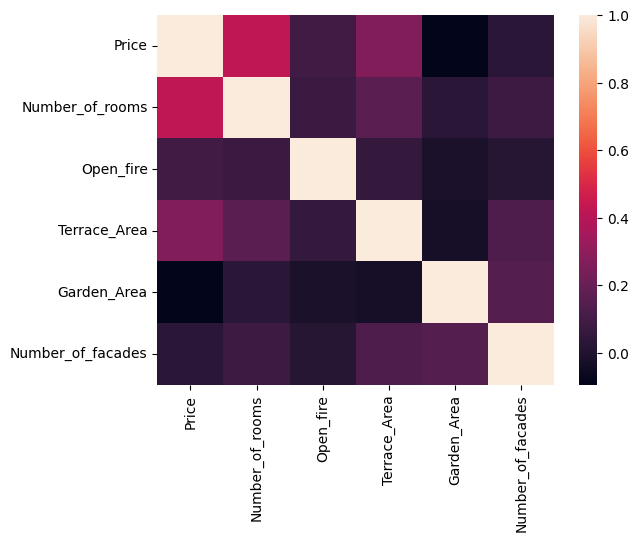

In [202]:
sns.heatmap(df_ap.corr())

In [203]:
contingency_table = pd.crosstab(df_ap['Fully_equipped_kitchen'], df_ap['Price'])

# Calculate the chi-squared test for independence
stat, p, dof, expected = chi2_contingency(contingency_table, correction=False)

#print p-value
print(p)

0.047686502540815606


We don't see a significance difference between those types. We'll divide by installed and not installed. 

In [204]:
df_ap.Fully_equipped_kitchen.value_counts()

INSTALLED             2276
HYPER_EQUIPPED        1149
USA_HYPER_EQUIPPED     624
SEMI_EQUIPPED          372
NOT_INSTALLED          198
USA_INSTALLED          180
USA_SEMI_EQUIPPED       44
USA_UNINSTALLED          4
Name: Fully_equipped_kitchen, dtype: int64

In [205]:
df_ap.groupby('Fully_equipped_kitchen').mean()

C:\Users\nacit\AppData\Local\Temp\ipykernel_24544\793951150.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ap.groupby('Fully_equipped_kitchen').mean()


,Price,Number_of_rooms,Open_fire,Terrace_Area,Garden_Area,Number_of_facades
Fully_equipped_kitchen,,,,,,
HYPER_EQUIPPED,400065.857267,2.126197,0.016536,20.615990,288.955056,2.573620
INSTALLED,304732.322056,2.015378,0.010984,18.353215,404.805128,2.435739
NOT_INSTALLED,283598.878788,2.020202,0.020202,18.059322,6497.440000,2.414141
SEMI_EQUIPPED,219815.884409,1.916667,0.013441,14.000000,4104.360000,2.511111
USA_HYPER_EQUIPPED,449718.064103,2.126603,0.008013,22.700665,236.885417,2.491266
USA_INSTALLED,340711.561111,2.000000,0.016667,14.623762,220.882353,2.453846
USA_SEMI_EQUIPPED,302838.636364,1.795455,0.022727,20.640000,150.000000,2.264706
USA_UNINSTALLED,606875.000000,2.750000,0.250000,18.666667,213.000000,4.000000


# Later analysis kitchen


In [161]:
df_ap.shape

(6769, 14)

In [132]:
df_ap.Fully_equipped_kitchen.value_counts()

1.0    5867
3.0    3011
2.0    1658
0.0     685
Name: Fully_equipped_kitchen, dtype: int64

In [116]:
#doing analyse on kitchen
df.Fully_equipped_kitchen[df.Type_of_property=='APARTMENT'].describe()

count          4847
unique            8
top       INSTALLED
freq           2276
Name: Fully_equipped_kitchen, dtype: object

In [117]:
df.Fully_equipped_kitchen[df.Type_of_property=='HOUSE'].describe()

count          6374
unique            8
top       INSTALLED
freq           3203
Name: Fully_equipped_kitchen, dtype: object

In [130]:
df_ap.isnull().sum()

Province                     0
Price                        0
Number_of_rooms              0
Living_Area                  0
Fully_equipped_kitchen    1927
Furnished                 1683
Open_fire                    0
Terrace                   1904
Terrace_Area              3037
Garden                    5726
Garden_Area               6218
Number_of_facades         2649
Swimming_pool             2854
State_of_the_building     1906
dtype: int64

In [186]:
df_ap = df_ap.replace({"Fully_equipped_kitchen":{"NOT_INSTALLED": 0, "INSTALLED": 1, "SEMI_EQUIPPED": 2, "HYPER_EQUIPPED": 3, "USA_UNINSTALLED": 0, "USA_INSTALLED": 1, "USA_SEMI_EQUIPPED": 2, "USA_HYPER_EQUIPPED": 3}})

In [207]:
df_ap.Fully_equipped_kitchen.value_counts()

1.0    2456
3.0    1773
2.0     416
0.0     202
Name: Fully_equipped_kitchen, dtype: int64

In [30]:
contingency_table = pd.crosstab(df_ap['Fully_equipped_kitchen'], df_ap['Price'])

# Calculate the chi-squared test for independence
stat, p, dof, expected = chi2_contingency(contingency_table, correction=False)

#print p-value
print(p)

NameError: name 'chi2_contingency' is not defined

This value is more significant. We will put the other values as 0. 

In [187]:
df_ap["Fully_equipped_kitchen"].fillna(0, inplace=True)

In [188]:
df_ap.Fully_equipped_kitchen.value_counts()

1.0    2454
0.0    2129
3.0    1772
2.0     414
Name: Fully_equipped_kitchen, dtype: int64

In [210]:
df_ap.isnull().sum()

Province                     0
Price                        0
Number_of_rooms              0
Living_Area                  0
Fully_equipped_kitchen       0
Furnished                 1684
Open_fire                    0
Terrace                   1910
Terrace_Area              3046
Garden                    5735
Garden_Area               6228
Number_of_facades         2652
Swimming_pool             2861
State_of_the_building     1907
dtype: int64

In [211]:
df_ap.State_of_the_building.value_counts()

AS_NEW            2311
GOOD              1723
JUST_RENOVATED     331
TO_BE_DONE_UP      320
TO_RENOVATE        179
TO_RESTORE          10
Name: State_of_the_building, dtype: int64

In [178]:
contingency_table = pd.crosstab(df_ap['Province'], df_ap['Price'])

# Calculate the chi-squared test for independence
stat, p, dof, expected = chi2_contingency(contingency_table, correction=False)

#print p-value
print(p)

3.3168033941493056e-140


We will make our first model with price of ap as target and the following features: province, living area, number of rooms, fully_equipped_kitchen. 

In [189]:
df_ap.head()

,Province,Price,Number_of_rooms,Living_Area,Fully_equipped_kitchen,Furnished,Open_fire,Terrace,Terrace_Area,Garden,Garden_Area,Number_of_facades,Swimming_pool,State_of_the_building
0,Brussels,450000,3,156.0,3.0,False,False,True,43.0,NaN,NaN,4.0,NaN,NaN
1,Brussels,450000,3,156.0,3.0,False,False,True,43.0,NaN,NaN,4.0,NaN,NaN
3,Brussels,485000,2,107.0,3.0,False,False,True,17.0,NaN,NaN,NaN,False,AS_NEW
4,Brussels,460000,3,147.0,3.0,False,False,True,52.0,NaN,NaN,2.0,NaN,NaN
5,Walloon Brabant,475000,3,115.0,0.0,False,False,True,20.0,NaN,NaN,NaN,NaN,AS_NEW


In [227]:
columns_to_keep = ['Price','Province','Number_of_rooms','Living_Area','Fully_equipped_kitchen']
df_model_ap=df_ap[columns_to_keep]

In [191]:
df_model_ap.head()

,Price,Province,Number_of_rooms,Living_Area,Fully_equipped_kitchen
0,450000,Brussels,3,156.0,3.0
1,450000,Brussels,3,156.0,3.0
3,485000,Brussels,2,107.0,3.0
4,460000,Brussels,3,147.0,3.0
5,475000,Walloon Brabant,3,115.0,0.0


Preprocessing: In the preprocessing stage, our goal ensure the model is able to interpret the data we feed into it. This includes converting categorical features into numerical ones. We can use Pandas get_dummies or Scikit-Lear

In [54]:
df_model_ap.head()

,Price,Province,Number_of_rooms,Living_Area,Fully_equipped_kitchen
0,450000.0,Brussels,3.0,156.0,3.0
1,450000.0,Brussels,3.0,156.0,3.0
3,485000.0,Brussels,2.0,107.0,3.0
4,460000.0,Brussels,3.0,147.0,3.0
5,475000.0,Walloon Brabant,3.0,115.0,0.0


In [106]:
df_model_ap['Living_Area'] = df_model_ap.Living_Area.astype(int)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'function'

In [229]:
# X=df_model_ap[['Province','Number_of_rooms','Living_Area','Fully_equipped_kitchen']].to_numpy()
# y= df[['Price']].to_numpy()

X=df_model_ap.drop('Price', axis=1)

In [230]:
y=df_model_ap['Price']

In [231]:
X.dtypes

Province                   object
Number_of_rooms             int32
Living_Area               float64
Fully_equipped_kitchen    float64
dtype: object

In [206]:
# X=X.to_numpy()
# y=y.to_numpy

In [232]:
# Get the columns name
X_columns_name = ['Province', 'Fully_equipped_kitchen']
# Label encode them
X = pd.get_dummies(X, columns=X_columns_name, prefix=X_columns_name, drop_first=False)

In [233]:
X.head()

,Number_of_rooms,Living_Area,Province_Antwerp,Province_Brussels,Province_East Flanders,Province_Flemish Brabant,Province_Hainaut,Province_Limburg,Province_Liège,Province_Luxembourg,Province_Namur,Province_Walloon Brabant,Province_West Flanders,Fully_equipped_kitchen_0.0,Fully_equipped_kitchen_1.0,Fully_equipped_kitchen_2.0,Fully_equipped_kitchen_3.0
0,3,156.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,3,156.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2,107.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,3,147.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
5,3,115.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [234]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [235]:
X_train.head()

,Number_of_rooms,Living_Area,Province_Antwerp,Province_Brussels,Province_East Flanders,Province_Flemish Brabant,Province_Hainaut,Province_Limburg,Province_Liège,Province_Luxembourg,Province_Namur,Province_Walloon Brabant,Province_West Flanders,Fully_equipped_kitchen_0.0,Fully_equipped_kitchen_1.0,Fully_equipped_kitchen_2.0,Fully_equipped_kitchen_3.0
1152,2,84.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
413,1,55.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4897,2,108.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2536,4,200.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
16314,1,65.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [1]:
X.head()

NameError: name 'X' is not defined

In [236]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(X_train, y_train)

LinearRegression()

In [237]:
predictions = lin.predict(X_test)
print('The R-Squared value for this model is {}'.format(round(lin.score(X_test, y_test), 4)))

The R-Squared value for this model is 0.3495


In [238]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
#Construct pipeline 
sc=StandardScaler()
poly=PolynomialFeatures(degree=1)
lin_reg=LinearRegression()


In [241]:
poly=PolynomialFeatures(degree=5)
lin_reg=LinearRegression()
model= Pipeline([('poly', poly),('regressor',lin_reg)])
model.fit(X, y)

In [240]:
y_pred=model.predict(X_test)
model.score(X,y)

0.4917023269194243

In [ ]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(X_train, y_train)

In [49]:
lr_model.score(X_test, y_test) 

-5.97236104470774e+23

What this means is ???% of the variance in our target variable is accounted for by our independent variables

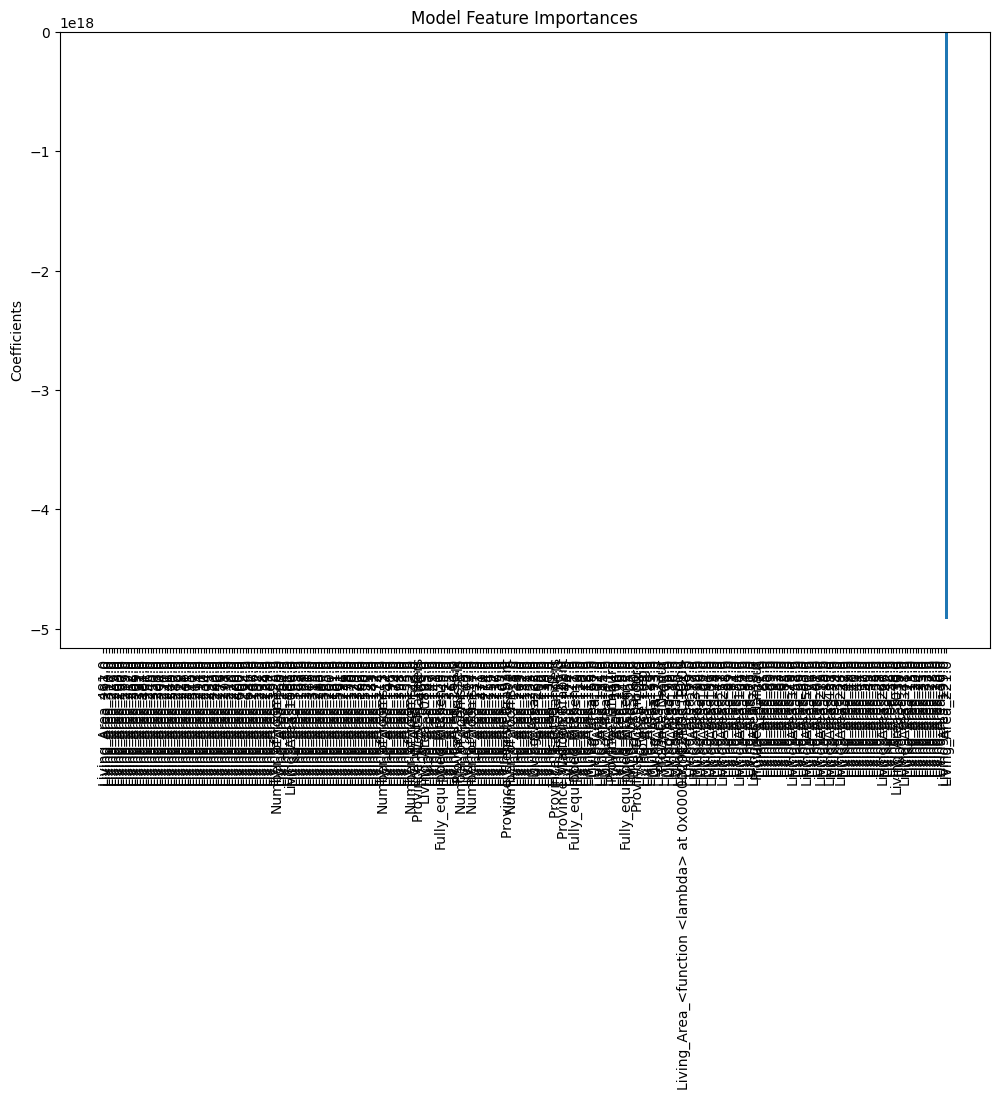

In [42]:
zipped = zip(lr_model.coef_, X_train.columns)
df_importance = pd.DataFrame(zipped).sort_values(by=0, ascending=False) 
df_importance.reset_index(inplace=True, drop=True)
df_importance.columns = ['Importance', 'Feature']
plt.figure(figsize=(12, 8))
plt.bar(x=df_importance['Feature'],
height=df_importance['Importance'])
plt.xticks(rotation=90)
plt.title('Model Feature Importances')
plt.ylabel('Coefficients')
plt.show()

In [185]:
df[df.Type_of_property=='APARTMENT'].head()

,Province,Type_of_property,Price,Number_of_rooms,Living_Area,Fully_equipped_kitchen,Furnished,Open_fire,Terrace,Terrace_Area,Garden,Garden_Area,Surface_area_of_the_plot_of_land,Number_of_facades,Swimming_pool,State_of_the_building
0,Brussels,APARTMENT,450000.0,3.0,156.0,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN
1,Brussels,APARTMENT,450000.0,3.0,156.0,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN
3,Brussels,APARTMENT,485000.0,2.0,107.0,USA_HYPER_EQUIPPED,False,False,True,17.0,NaN,NaN,NaN,NaN,False,AS_NEW
4,Brussels,APARTMENT,460000.0,3.0,147.0,USA_HYPER_EQUIPPED,False,False,True,52.0,NaN,NaN,NaN,2.0,NaN,NaN
5,Walloon Brabant,APARTMENT,475000.0,3.0,115.0,NOT_INSTALLED,False,False,True,20.0,NaN,NaN,NaN,NaN,NaN,AS_NEW


UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U7'), dtype('float64')) -> None

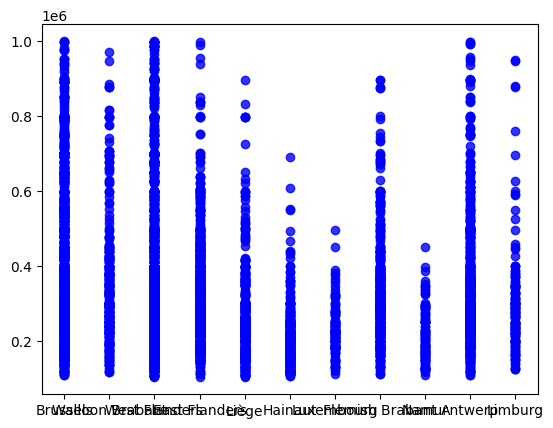

In [46]:
import seaborn as sns
sns.regplot(data=df_model_ap,
            y='Price',
            x='Province',
            color='b')
plt.show()
sns.regplot(data=df_model_ap,
            y='Price',
            x='Number_of_rooms',
            color='b')
plt.show()

In [47]:
df_model_ap.head()

,Price,Province,Number_of_rooms,Living_Area,Fully_equipped_kitchen
0,450000.0,Brussels,3.0,156.0,3.0
1,450000.0,Brussels,3.0,156.0,3.0
3,485000.0,Brussels,2.0,107.0,3.0
4,460000.0,Brussels,3.0,147.0,3.0
5,475000.0,Walloon Brabant,3.0,115.0,0.0


In [106]:
usakitchen= ["USA_UNINSTALLED", "USA_INSTALLED", "USA_SEMI_EQUIPPED", "USA_HYPER_EQUIPPED"]
normalkitchen=["NOT_INSTALLED", "INSTALLED", "SEMI_EQUIPPED", "HYPER_EQUIPPED"]

# wht after else? 
kitchen_type=df['Fully_equipped_kitchen'].apply(lambda kitchen: "usa" if kitchen in usakitchen else "normal" if kitchen in normalkitchen)

#First analysus which kind K 

SyntaxError: expected 'else' after 'if' expression (2129263404.py, line 4)

In [104]:
usa_kitchen.head(10)

0     yes
1     yes
3     yes
4     yes
5      no
6     yes
7     yes
8     yes
9     yes
10     no
Name: Fully_equipped_kitchen, dtype: object

In [87]:
df_house.isnull().sum()

Postal_code                            0
Type_of_property                       0
Subtype_of_property                    0
Price                                 12
Number_of_rooms                        0
Living_Area                          453
Fully_equipped_kitchen              2035
Furnished                           1543
Open_fire                              0
Terrace                             3124
Terrace_Area                        5780
Garden                              3937
Garden_Area                         5591
Surface_area_of_the_plot_of_land       0
Number_of_facades                   1201
Swimming_pool                       4086
State_of_the_building               1122
dtype: int64

In [79]:
df.head()

,Postal_code,Type_of_property,Subtype_of_property,Price,Number_of_rooms,Living_Area,Fully_equipped_kitchen,Furnished,Open_fire,Terrace,Terrace_Area,Garden,Garden_Area,Surface_area_of_the_plot_of_land,Number_of_facades,Swimming_pool,State_of_the_building
0,1130,APARTMENT,PENTHOUSE,450000.0,3.0,156.0,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN
1,1140,APARTMENT,PENTHOUSE,450000.0,3.0,156.0,USA_HYPER_EQUIPPED,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN
3,1180,APARTMENT,APARTMENT,485000.0,2.0,107.0,USA_HYPER_EQUIPPED,False,False,True,17.0,NaN,NaN,NaN,NaN,False,AS_NEW
4,1000,APARTMENT,DUPLEX,460000.0,3.0,147.0,USA_HYPER_EQUIPPED,False,False,True,52.0,NaN,NaN,NaN,2.0,NaN,NaN
5,1340,APARTMENT,APARTMENT,475000.0,3.0,115.0,NOT_INSTALLED,False,False,True,20.0,NaN,NaN,NaN,NaN,NaN,AS_NEW


In [69]:
df.isnull().sum()

Postal_code                             0
Type_of_property                        0
Subtype_of_property                     0
Price                                  19
Type_of_sale                            0
Number_of_rooms                         0
Living_Area                           808
Fully_equipped_kitchen               4103
Furnished                            3366
Open_fire                               0
Terrace                              5175
Terrace_Area                         9119
Garden                              10146
Garden_Area                         12333
Surface_area_of_the_plot_of_land     7338
Number_of_facades                    4014
Swimming_pool                        7109
State_of_the_building                3115
dtype: int64

In [75]:
print(df_ap.Fully_equipped_kitchen       value_counts())

Postal_code  Type_of_property  Subtype_of_property   Price     Type_of_sale      Number_of_rooms  Living_Area  Fully_equipped_kitchen  Furnished  Open_fire  Terrace  Terrace_Area  Garden  Garden_Area  Surface_area_of_the_plot_of_land  Number_of_facades  Swimming_pool  State_of_the_building
1000         HOUSE             APARTMENT_BLOCK       465000.0  residential_sale  4.0              180.0        HYPER_EQUIPPED          False      False      True     10.0          True    35.0         112.0                             2.0                False          AS_NEW                   1
4680         HOUSE             EXCEPTIONAL_PROPERTY  399000.0  residential_sale  3.0              223.0        HYPER_EQUIPPED          False      False      True     200.0         True    416.0        644.0                             3.0                True           AS_NEW                   1
                               HOUSE                 120000.0  residential_sale  2.0              95.0         NOT_IN

In [72]:
for col in df.columns:     if df.Postal_code.nunique <2: 
        print(df['col'])

TypeError: '<' not supported between instances of 'method' and 'int'

df.drop(columns=['type_of_sale','furnished','surface_of_the_plot_of_land'],inplace=True)
df.shape

In [ ]:
print(Postal_code.info())
print(Postal_code.isna().sum())
Postal_code.describe()

In [59]:
print(df.info())
print(df.isna().sum())
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16468 entries, 0 to 19272
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Postal_code                       16468 non-null  int64  
 1   Type_of_property                  16468 non-null  object 
 2   Subtype_of_property               16468 non-null  object 
 3   Price                             16449 non-null  float64
 4   Type_of_sale                      16468 non-null  object 
 5   Number_of_rooms                   16468 non-null  float64
 6   Living_Area                       15660 non-null  float64
 7   Fully_equipped_kitchen            12365 non-null  object 
 8   Furnished                         13102 non-null  object 
 9   Open_fire                         16468 non-null  bool   
 10  Terrace                           11293 non-null  object 
 11  Terrace_Area                      7349 non-null   float64
 12  Gard

,Postal_code,Price,Number_of_rooms,Living_Area,Terrace_Area,Garden_Area,Surface_area_of_the_plot_of_land,Number_of_facades
count,16468.000000,1.644900e+04,16468.000000,15660.000000,7349.000000,4135.000000,9130.000000,12454.000000
mean,5021.688608,4.725664e+05,2.972674,177.924840,28.891822,870.207497,1375.646440,2.776377
std,3145.245271,5.357725e+05,1.597535,191.566421,55.840009,5745.523444,10167.340787,0.858784
min,1000.000000,2.000000e+04,0.000000,13.000000,1.000000,1.000000,0.000000,1.000000
25%,1790.000000,2.300000e+05,2.000000,95.000000,10.000000,80.000000,171.000000,2.000000
50%,4500.000000,3.290000e+05,3.000000,140.000000,19.000000,208.000000,400.000000,3.000000
75%,8400.000000,4.950000e+05,4.000000,205.000000,33.000000,582.500000,908.750000,4.000000
max,9992.000000,1.100000e+07,32.000000,11000.000000,3286.000000,150000.000000,500000.000000,6.000000


In [ ]:
#(4) Converting categorical data to numerical values.   
df = df.replace({"Type_of_property":{"APARTMENT": 1, "APARTMENT_GROUP": 2, "HOUSE": 3, "HOUSE_GROUP": 4}})
df = df.replace({"Subtype_of_property":{"PENTHOUSE": 1,"APARTMENT": 2, "DUPLEX": 3, "GROUND_FLOOR": 4, "FLAT_STUDIO": 5,"LOFT": 6, "TRIPLEX": 7, "SERVICE_FLAT": 8, "APARTMENT_GROUP": 9, "KOT": 10, "HOUSE": 11, "HOUSE_GROUP": 12, "APARTMENT_BLOCK": 13, "VILLA": 14, "MANSION": 15, "MIXED_USE_BUILDING": 16, "EXCEPTIONAL_PROPERTY": 17, "COUNTRY_COTTAGE": 18, "BUNGALOW": 19, "TOWN_HOUSE": 20, "FARMHOUSE": 21, "CHALET": 22, "CASTLE": 23, "OTHER_PROPERTY": 24, "MANOR_HOUSE": 25}})    
df = df.replace({"Type_of_sale":{"residential_sale": 1, "group_sale": 2, "first_session_with_reserve_price": 3, "annuity_monthly_amount": 4, "annuity_without_lump_sum": 5}})
df = df.replace({"Fully_equipped_kitchen":{"NOT_INSTALLED": 1, "INSTALLED": 2, "SEMI_EQUIPPED": 3, "HYPER_EQUIPPED": 4, "USA_UNINSTALLED": 5, "USA_INSTALLED": 6, "USA_SEMI_EQUIPPED": 7, "USA_HYPER_EQUIPPED": 8}})
df = df.replace({"State_of_the_building":{"AS_NEW": 1, "JUST_RENOVATED": 2, "GOOD": 3, "TO_RESTORE": 4,"TO_RENOVATE": 4, "TO_BE_DONE_UP": 4}})


NameError: name 'Postal_code' is not defined

In [28]:
#add column next to Price with region Flanders, Wallonia, Brussels
df.insert(1, 'Region', df.Postal_code.apply(region))

#add column next to Region with the provinces
df.insert(2, 'Province', df.Postal_code.apply(provinces))

In [29]:
df.head()

,Postal_code,Region,Province,Type_of_property,Subtype_of_property,Price,Type_of_sale,Number_of_rooms,Living_Area,Fully_equipped_kitchen,Furnished,Open_fire,Terrace,Terrace_Area,Garden,Garden_Area,Surface_area_of_the_plot_of_land,Number_of_facades,Swimming_pool,State_of_the_building
0,1130,Brussels,Brussels,1,1,450000.0,1,3.0,156.0,8.0,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN
1,1140,Brussels,Brussels,1,1,450000.0,1,3.0,156.0,8.0,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN
3,1180,Brussels,Brussels,1,2,485000.0,1,2.0,107.0,8.0,False,False,True,17.0,NaN,NaN,NaN,NaN,False,1.0
4,1000,Brussels,Brussels,1,3,460000.0,1,3.0,147.0,8.0,False,False,True,52.0,NaN,NaN,NaN,2.0,NaN,NaN
5,1340,Wallonia,Walloon Brabant,1,2,475000.0,1,3.0,115.0,1.0,False,False,True,20.0,NaN,NaN,NaN,NaN,NaN,1.0


In [31]:
corr=df.corr().Price
print(corr)

Postal_code                        -0.112448
Type_of_property                    0.081557
Subtype_of_property                 0.133763
Price                               1.000000
Type_of_sale                       -0.061712
Number_of_rooms                     0.365402
Living_Area                         0.436748
Fully_equipped_kitchen              0.209460
Open_fire                           0.121475
Terrace_Area                        0.197134
Garden_Area                         0.263325
Surface_area_of_the_plot_of_land    0.351372
Number_of_facades                   0.161037
State_of_the_building              -0.191022
Name: Price, dtype: float64


C:\Users\nacit\AppData\Local\Temp\ipykernel_18800\3770545921.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=df.corr().Price


In [22]:
df.Province.unique()

array(['Brussels', 'Walloon Brabant', 'West Flanders', 'East Flanders\t',
       'Liège', 'Hainaut', 'Luxembourg', 'Flemish Brabant', 'Namur',
       'Antwerp', 'Limburg'], dtype=object)

This gives us the insight that we need to clean the data. We have two columns which we don't need (first and last column). They were imported from our previous dataset resulting from the data collection part (1). Next, we want to remove the duplicates (2). In a next step we don't want to have rows with only missing values (3). In a last step, we prefer to have a dataset which consists only of numerical values. We will use dictionnaries to map string values to numbers. We leave 'Nan' and 'None' as it is. We also leave 'True' and 'False' as it is. This is threated as 1 or 0. The locality column gives information about the postal code of each city hence we can rename it to Postal_code(5).  

In [776]:
# Cleaning the dataset

#(1) Drop indices as Pandas creates indices too
df.drop('Unnamed: 0.1', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

#(2) Remove duplicates 
df.drop_duplicates(inplace=True)

#(3) No blank spaces. This method will delete the rows with ALL Nan values
df.dropna(how='all') 

#(4) Converting categorical data to numerical values.   
df = df.replace({"Type_of_property":{"APARTMENT": 1, "APARTMENT_GROUP": 2, "HOUSE": 3, "HOUSE_GROUP": 4}})
df = df.replace({"Subtype_of_property":{"PENTHOUSE": 1,"APARTMENT": 2, "DUPLEX": 3, "GROUND_FLOOR": 4, "FLAT_STUDIO": 5,"LOFT": 6, "TRIPLEX": 7, "SERVICE_FLAT": 8, "APARTMENT_GROUP": 9, "KOT": 10, "HOUSE": 11, "HOUSE_GROUP": 12, "APARTMENT_BLOCK": 13, "VILLA": 14, "MANSION": 15, "MIXED_USE_BUILDING": 16, "EXCEPTIONAL_PROPERTY": 17, "COUNTRY_COTTAGE": 18, "BUNGALOW": 19, "TOWN_HOUSE": 20, "FARMHOUSE": 21, "CHALET": 22, "CASTLE": 23, "OTHER_PROPERTY": 24, "MANOR_HOUSE": 25}})    
df = df.replace({"Type_of_sale":{"residential_sale": 1, "group_sale": 2, "first_session_with_reserve_price": 3, "annuity_monthly_amount": 4, "annuity_without_lump_sum": 5}})
df = df.replace({"Fully_equipped_kitchen":{"NOT_INSTALLED": 1, "INSTALLED": 2, "SEMI_EQUIPPED": 3, "HYPER_EQUIPPED": 4, "USA_UNINSTALLED": 5, "USA_INSTALLED": 6, "USA_SEMI_EQUIPPED": 7, "USA_HYPER_EQUIPPED": 8}})
df = df.replace({"State_of_the_building":{"AS_NEW": 1, "JUST_RENOVATED": 2, "GOOD": 3, "TO_RESTORE": 4,"TO_RENOVATE": 4, "TO_BE_DONE_UP": 4}})

#(5) Change the name of locality to Postal_code:
df.rename(columns={'Locality' :'Postal_code'},inplace=True)



Checking the different datatypes in our dataset also helps us understanding the dataset. We can do that as follows:

In [777]:
# Check type
df.dtypes

# Check shape
df.shape


(17274, 18)

This leaves us with a dataset of 17274 rows and 18 columns. If needed, several 'float' types can be converted to integers. We can do this for the Price column. Here we're not interested in empty values and we would like to convert the type to int. 


In [778]:
df.dropna(subset=['Price'], inplace=True)


In [779]:
df['Price'] = df.Price.astype(int)

In [781]:
df.head()

,Postal_code,Type_of_property,Subtype_of_property,Price,Type_of_sale,Number_of_rooms,Living_Area,Fully_equipped_kitchen,Furnished,Open_fire,Terrace,Terrace_Area,Garden,Garden_Area,Surface_area_of_the_plot_of_land,Number_of_facades,Swimming_pool,State_of_the_building
0,1130,1,1,450000,1,3.0,156.0,8.0,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN
1,1140,1,1,450000,1,3.0,156.0,8.0,False,False,True,43.0,NaN,NaN,NaN,4.0,NaN,NaN
3,1180,1,2,485000,1,2.0,107.0,8.0,False,False,True,17.0,NaN,NaN,NaN,NaN,False,1.0
4,1000,1,3,460000,1,3.0,147.0,8.0,False,False,True,52.0,NaN,NaN,NaN,2.0,NaN,NaN
5,1340,1,2,475000,1,3.0,115.0,1.0,False,False,True,20.0,NaN,NaN,NaN,NaN,NaN,1.0


It's also worth checking if there are special things to notice in the unique values of each column. 

In [782]:
df['Type_of_property'].value_counts() 

3    9217
1    7430
Name: Type_of_property, dtype: int64

We can drop property types 2 and 4 as they are basically apartment blocks and hence do not include sale price for 1 particular house or apartment price. 


In [783]:
# Filtering by Type of property. 
# Notice that df.Type_of_property is the same as df['Type_of_property']. 


Let's check the unique values from other columns 

In [784]:
df.Type_of_property.value_counts()

3    9217
1    7430
Name: Type_of_property, dtype: int64

In [785]:
df.Type_of_sale.value_counts()

1    16449
3      148
4       49
5        1
Name: Type_of_sale, dtype: int64

Here we see that mainly saletype 1 (Type_of_sale) is present in our dataset. Upon further analysing we see that the other values for Type_of_sale are especially meant for life annuity sales or auctions. Those sale prices are not final sale prices and can be deleted. You can also see this upon doing simple statistics on the price of properties. 

In [786]:
#CHECK
df.loc[df.Price.idxmin(),'Type_of_sale']

5

The lowest prices are coming from the salestypes other than 1. We decide to work further with a dataset with only salestype 1 (residential sales). 

In [787]:
df=df[df.Type_of_sale==1]

In [788]:
#This column can then be deleted 
df.drop('Type_of_sale', axis=1, inplace=True)

# Step 2: Data Analysis

In [789]:
df.shape

(16449, 17)

We decide to conduct our data analysis with 16449 rows and 17 columns. Let's answer a few questions that we're interested as part of the data analysis:

 - What is the correlation between the variables and the price and how are the variables correlated to each other? 
 - Which variables have the greatest/least influence on the price? 

 The correlation between variables and the price can be measured using the Pearson correlation coefficient, which ranges between -1 and 1. A value of 1 indicates a perfect positive correlation, a value of -1 indicates a perfect negative correlation, and a value of 0 indicates no correlation. We can get this information bu ising the corr() function in order to get a correlation matrix. 



In [790]:
corr_matrix = df.corr()

#We want to know the correlation between Price and other variables: 
df.corr().Price

C:\Users\nacit\AppData\Local\Temp\ipykernel_3904\4201040309.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()
C:\Users\nacit\AppData\Local\Temp\ipykernel_3904\4201040309.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().Price


Postal_code                        -0.114205
Type_of_property                    0.081799
Subtype_of_property                 0.134400
Price                               1.000000
Number_of_rooms                     0.366331
Living_Area                         0.436421
Fully_equipped_kitchen              0.207457
Open_fire                           0.122738
Terrace_Area                        0.197334
Garden_Area                         0.263415
Surface_area_of_the_plot_of_land    0.352022
Number_of_facades                   0.163954
State_of_the_building              -0.189991
Name: Price, dtype: float64

In [791]:
#We can further adjust the code to show correlations of 0.15 or more
df.corr()[abs(df.corr().Price)>0.15].Price

C:\Users\nacit\AppData\Local\Temp\ipykernel_3904\2491476606.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()[abs(df.corr().Price)>0.15].Price


Price                               1.000000
Number_of_rooms                     0.366331
Living_Area                         0.436421
Fully_equipped_kitchen              0.207457
Terrace_Area                        0.197334
Garden_Area                         0.263415
Surface_area_of_the_plot_of_land    0.352022
Number_of_facades                   0.163954
State_of_the_building              -0.189991
Name: Price, dtype: float64

We will also use the correlation matrix to see how the variables are related to each other: 

C:\Users\nacit\AppData\Local\Temp\ipykernel_3904\3741788573.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


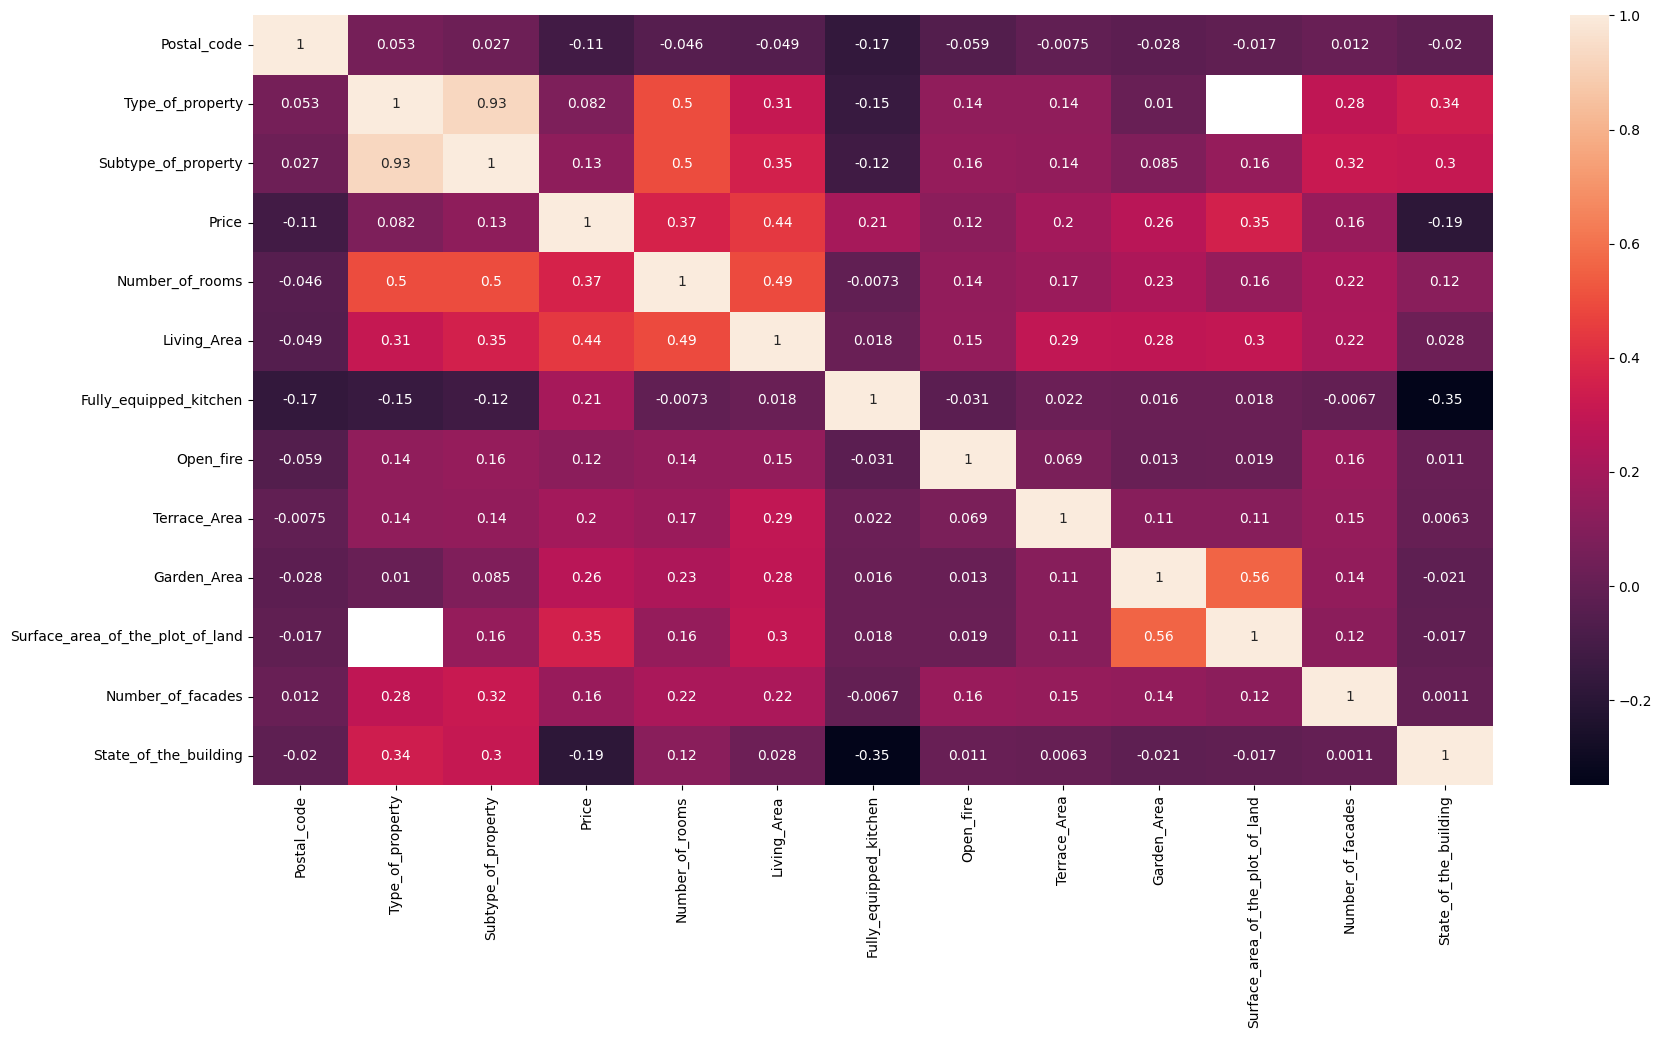

In [792]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

We can visualize the importance of the variables that have a high influence on the sale price. 

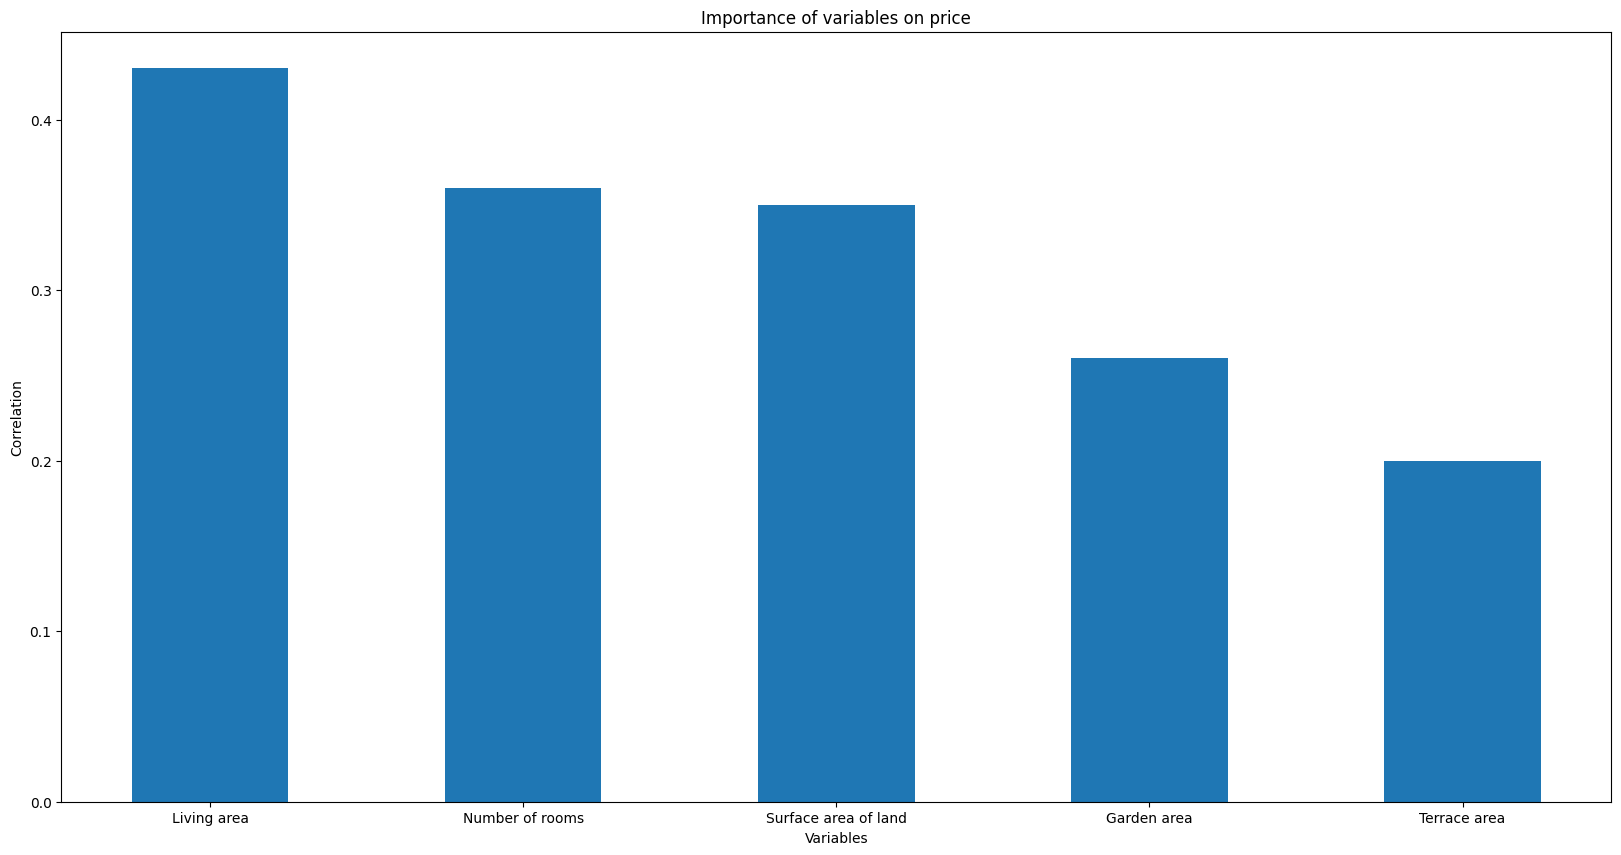

In [793]:
# data for the chart
variables = ['Living area', 'Number of rooms', 'Surface area of land', 'Garden area', 'Terrace area']
correlations = [0.43, 0.36, 0.35, 0.26, 0.20]

# create the chart
fig, ax = plt.subplots()
ax.bar(variables, correlations, width=0.5, bottom=0, align='center', tick_label=variables)
plt.title("Importance of variables on price")
plt.xlabel("Variables")
plt.ylabel("Correlation")
plt.show()

We see that the most important variables that have an influence on the price of a property are Living area, number of rooms, surface area of the land, garden area and terrace area.  When we compare the influence of variables on each other we can also mark important findings. We see that the price of house is negatively correlated with state of building. This looks like the 'higher' the state of building is, the lower the price will be but the categorization of state of building was modelled with 1 as new and 4 as to be renovated so in this case the negative correlation should be interpreted as a positive one. Meaning the newer the state of the property, the higher the price. We can also conclude some insights about the correlation between several variables. The higher the garden area, the higher the surface area of the land will be so this results in a higher correlation (0.56). We also know that the more rooms in a house, the more the living area will be. This translates in a higher correlation between 'number of rooms' and 'living area'.

In [794]:
df.shape

(16449, 17)

- How many qualitative and quantitative variables are there?

After cleaning the data we're left with 16449 rows and 17 columns. The 7 quantitative variables in the dataframe are: Price, Number of rooms, Living Area (in square meter), Terrace Area (in square meter), Garden_Area (in square meter), Surface area of land(in square meter) and Number of facades. The 10 qualitative variables in the dataframe are: Postal code, Type of property, Subtype of property, Type of sale, Fully equipped kitchen, Furnished, Open fire, Terrace, Garden, Swimming pool and State of the building.

- What is the percentage of missing values per column?



In [795]:
percent_missing = (df.isnull().sum() / len(df))* 100
print(percent_missing.round(2))

Postal_code                          0.00
Type_of_property                     0.00
Subtype_of_property                  0.00
Price                                0.00
Number_of_rooms                      0.00
Living_Area                          4.91
Fully_equipped_kitchen              24.90
Furnished                           20.45
Open_fire                            0.00
Terrace                             31.41
Terrace_Area                        55.35
Garden                              61.63
Garden_Area                         74.90
Surface_area_of_the_plot_of_land    44.57
Number_of_facades                   24.37
Swimming_pool                       43.16
State_of_the_building               18.93
dtype: float64


The highest percentages are in terrace area and garden area as they depend on the existence of a terrace and garden. 


## Step 3 : Data Interpretation

In order to answer some questions about the dataset, we need to be able to plot the outliers. We will do this for the Price column and use a sample size of 500. 

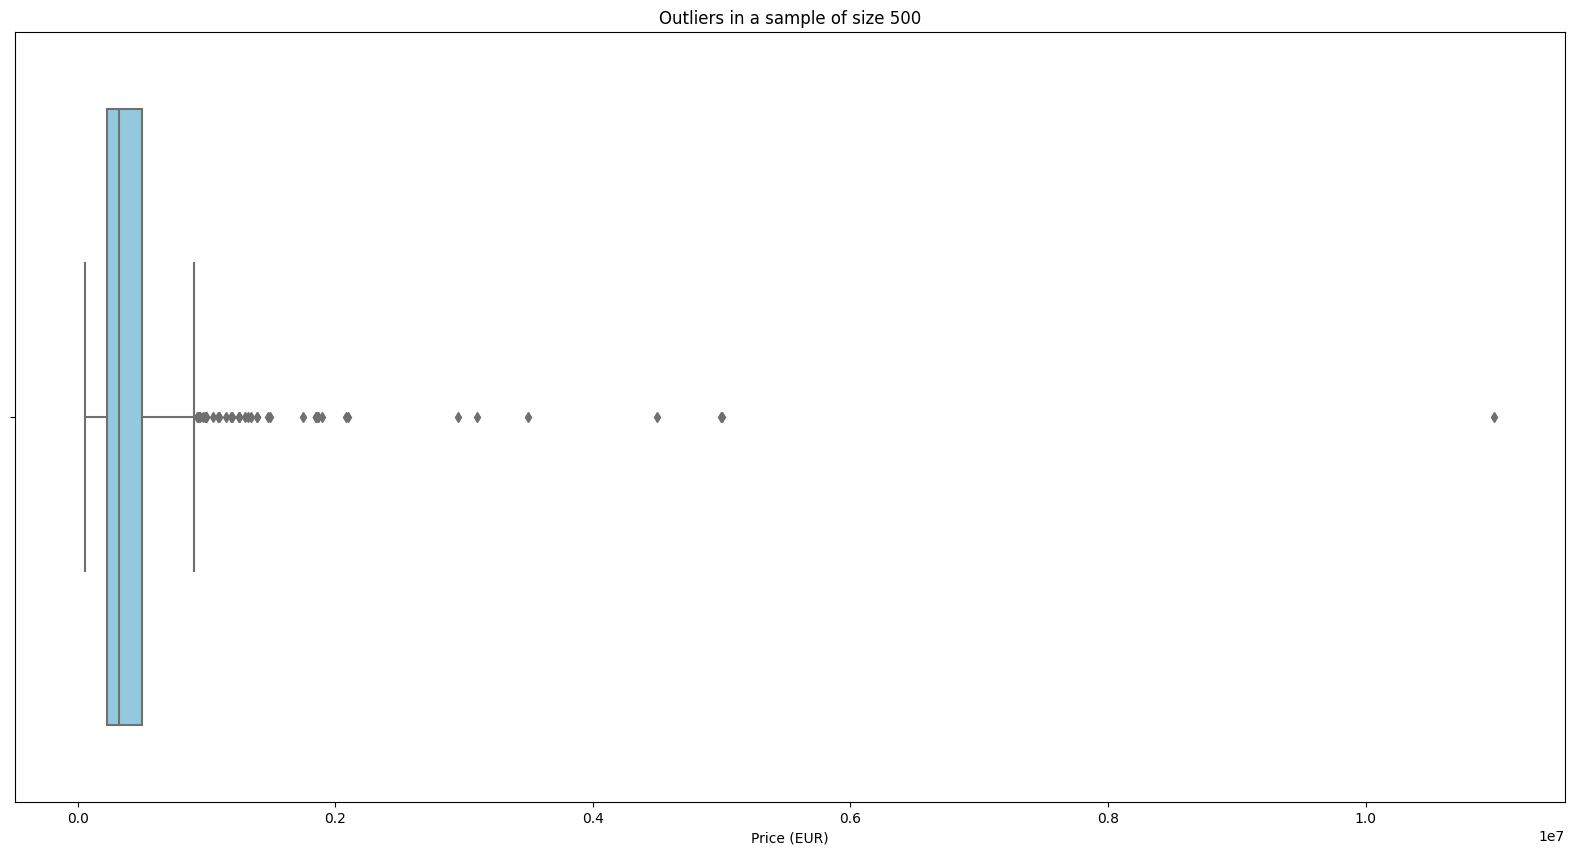

In [796]:
# Sample 500 rows from the dataframe
len_sample=500
df_sample = df.sample(len_sample)

# Create a box plot of the 'Price' column
sns.boxplot(x=df_sample['Price'], color='skyblue')

# Add title and x-axis label
plt.title(f"Outliers in a sample of size {len_sample}")
plt.xlabel('Price (EUR)')

# Show plot
plt.show()

After removing the outliers and the errors found in the dataset. We can work with the new dataset in a price range from 100 000 EUR tot 1 000 000 EUR.  

In [797]:
df=df[(df.Price>100000) & (df.Price <1000000)]

We would like also like to get an idea about how well the price distribution on this dataset is by using a distplot. 

C:\Users\nacit\AppData\Local\Temp\ipykernel_3904\2574419074.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Price'], color = 'r')


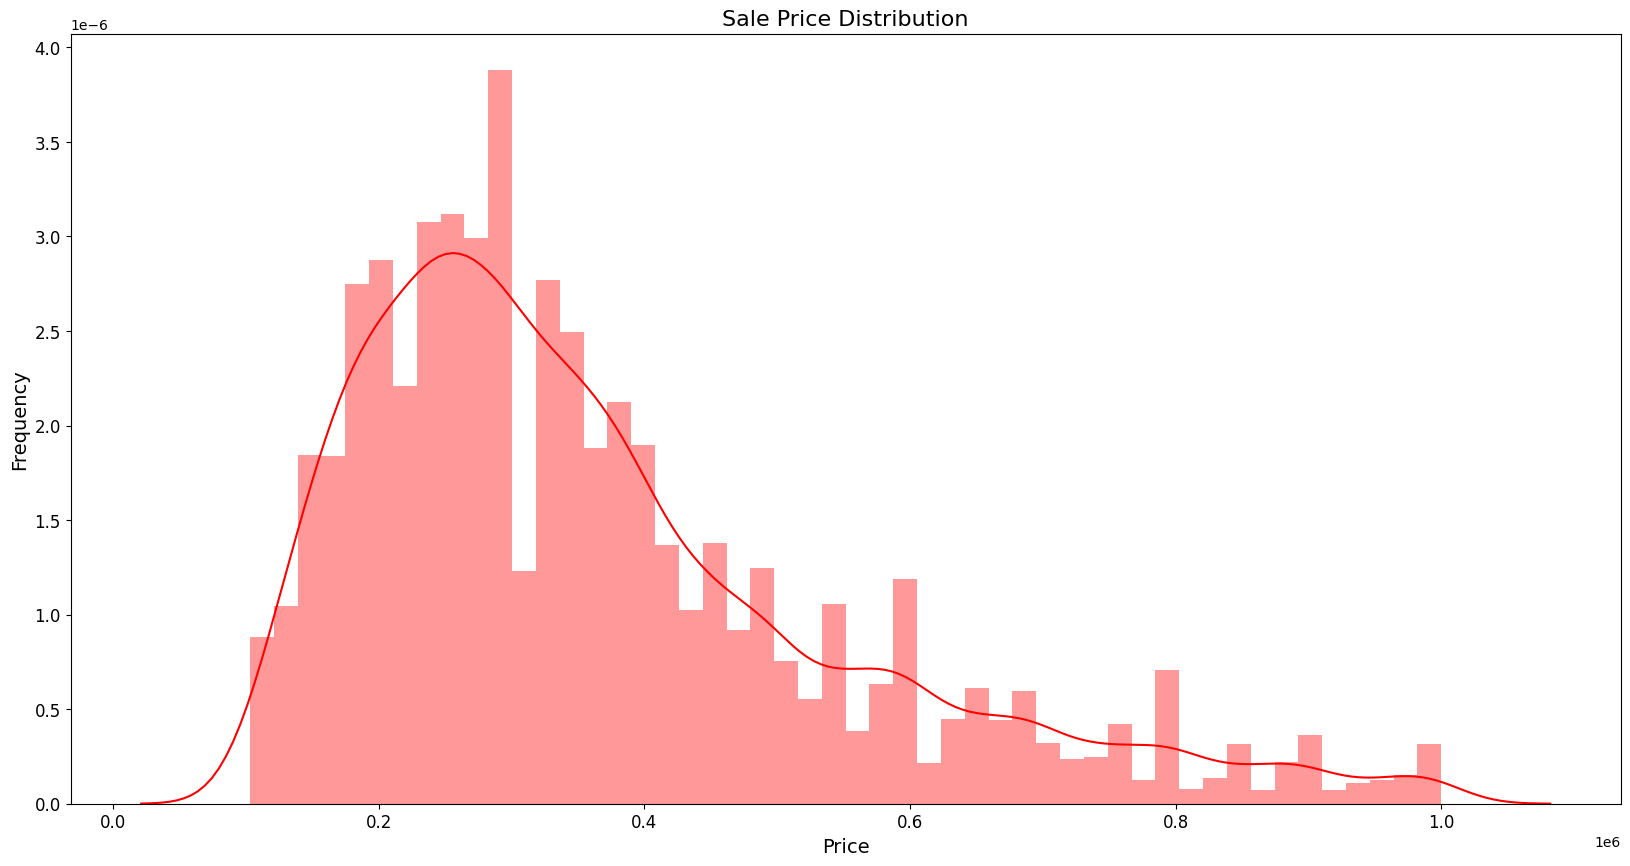

In [798]:
sns.distplot(df['Price'], color = 'r')
plt.title('Sale Price Distribution', fontsize = 16)
plt.xlabel('Price', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig('distplot.png')
plt.show()

Let's also have a look on properties by surface area (living area). We plot a histogram with widt=50. This means that we will count the number of properties with a surface area from 0 to 50 m², 50 to 100 m² and so on. 

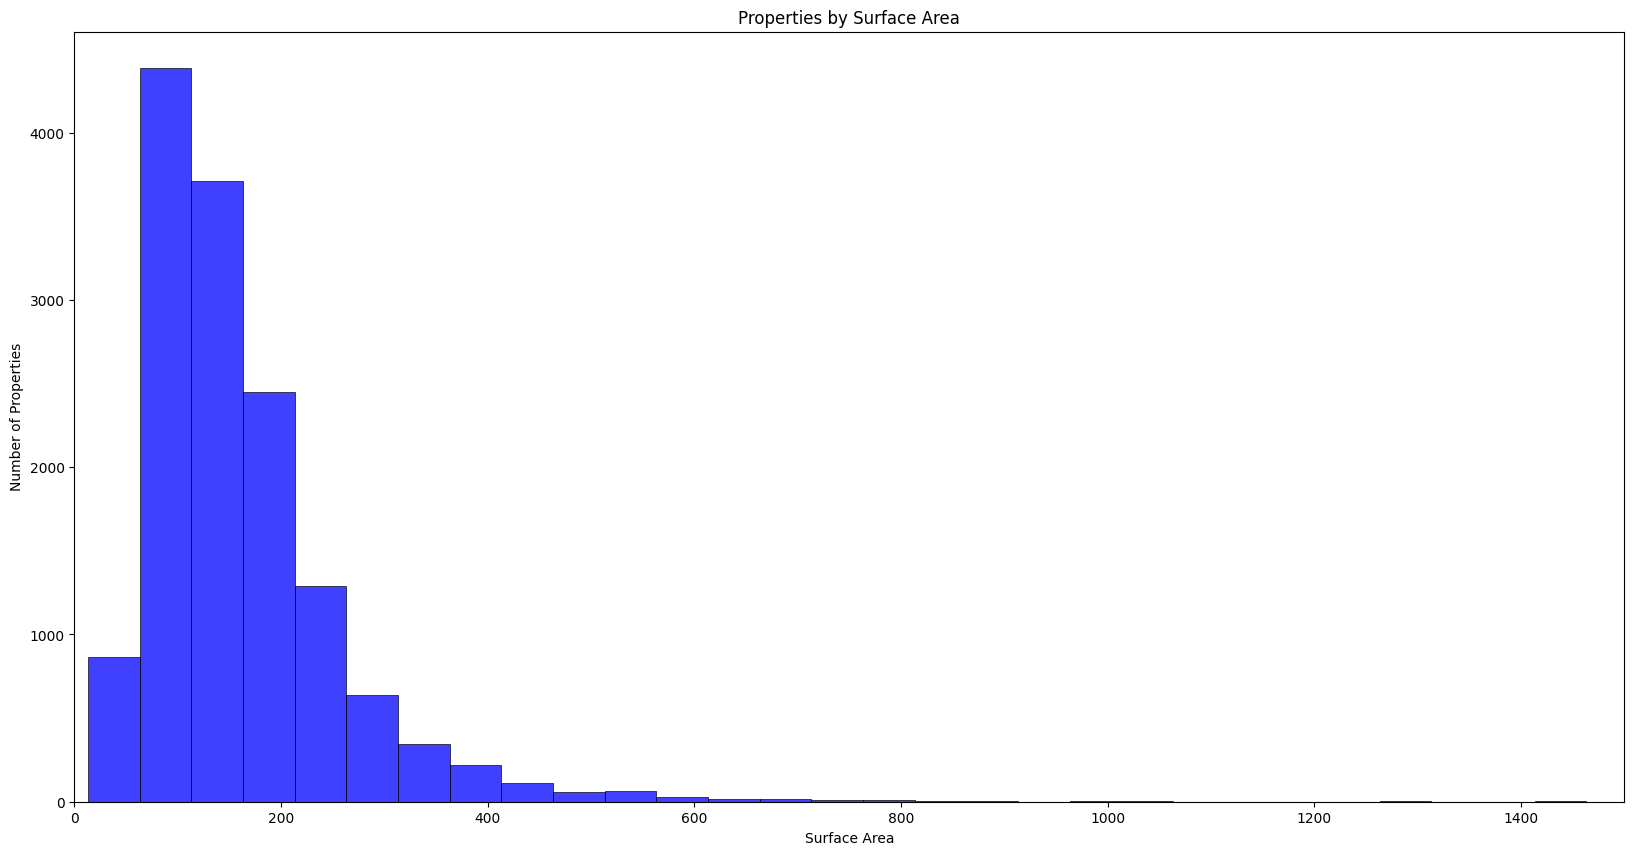

In [799]:
sns.histplot(data=df, x='Living_Area',binwidth=50, color='blue')

# Add title and labels
plt.title('Properties by Surface Area')
plt.xlabel('Surface Area')
plt.ylabel('Number of Properties')

# Show plot
plt.xlim(0, 1500)

plt.show()

As part of the data interpretation we're also interested in the most expensive/less expensive municipalities in Belgium. For this analysis we're going to desribe the Average price, median price and price per square meter for Belgium overall and we'll repeat the process for Flanders and Wallonia too to see if there are any differences. 
 
 


In order to have findings about the regions, we need to link the postal codes with the region. In a later analysis we will also divide the dataset by province. The codes below will link the postal codes with the region and province associated with the postal code. We will categorize Brussels as a province too. 

In [800]:
def region(postal_code):
    if 1000 <= postal_code < 1300:
        return "Brussels"
    elif (postal_code >= 1300 and postal_code < 1500) or (postal_code >= 4000 and postal_code < 8000):
        return "Wallonia"
    else:
        return "Flanders"

In [801]:
def provinces(postal_code):
    if 1000 <= postal_code < 1300:
        return "Brussels"
    elif 1300 <= postal_code < 1500:
        return "Walloon Brabant"
    elif (postal_code >= 1500 and postal_code < 2000) or (postal_code >= 3000 and postal_code < 3500):
        return "Flemish Brabant"
    elif 2000 <= postal_code < 3000:
        return "Antwerp"
    elif 3500 <= postal_code < 4000:
        return "Limburg"
    elif 4000 <= postal_code < 5000:
        return "Liège"
    elif 5000 <= postal_code < 6000:
        return "Namur"
    elif (postal_code >= 6000 and postal_code < 6600) or (postal_code >= 7000 and postal_code < 8000):
        return "Hainaut" 
    elif 6600 <= postal_code < 7000:
        return "Luxembourg"
    elif 8000 <= postal_code < 9000:
        return "West Flanders"  
    else: 
        return "East Flanders	"

In a next step we add those columns to the dataset:

In [802]:
#add column next to Price with region Flanders, Wallonia, Brussels
df.insert(1, 'Region', df.Postal_code.apply(region))

#add column next to Region with the provinces
df.insert(2, 'Province', df.Postal_code.apply(provinces))


To give information about the most/less expensive properties, we need to add an extra column which is the price per square meter. 

In [803]:
#ADelete missing values in living area and create new datasets for each region where we add the price per sqm.
df_bel=df.dropna(subset=['Living_Area'])

#Add new column Price_per_sqm to the dataset
df_bel['Price_per_sqm']=df.Price/df.Living_Area 

df_wal=df_bel[df_bel.Region=="Wallonia"]

df_flan=df_bel[df_bel.Region=="Flanders"]



C:\Users\nacit\AppData\Local\Temp\ipykernel_3904\1624782107.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bel['Price_per_sqm']=df.Price/df.Living_Area


In [804]:
#Sort the values from the belgian dataset according to the price per sqm.
df_bel.sort_values('Price_per_sqm')

,Postal_code,Region,Province,Type_of_property,Subtype_of_property,Price,Number_of_rooms,Living_Area,Fully_equipped_kitchen,Furnished,Open_fire,Terrace,Terrace_Area,Garden,Garden_Area,Surface_area_of_the_plot_of_land,Number_of_facades,Swimming_pool,State_of_the_building,Price_per_sqm
18057,4000,Wallonia,Liège,1,2,363000,2.0,10893.0,2.0,False,False,True,844.0,NaN,NaN,NaN,NaN,False,1.0,33.324153
12140,6747,Wallonia,Luxembourg,3,11,470000,4.0,2721.0,2.0,False,False,NaN,NaN,NaN,NaN,2721.0,4.0,False,NaN,172.730614
11554,7170,Wallonia,Hainaut,3,11,649000,4.0,3410.0,NaN,False,False,NaN,NaN,NaN,NaN,0.0,4.0,False,1.0,190.322581
16194,8570,Flanders,West Flanders,1,2,220500,2.0,1030.0,2.0,NaN,False,True,7.0,NaN,NaN,NaN,4.0,False,1.0,214.077670
16195,8570,Flanders,West Flanders,1,2,228500,2.0,1030.0,2.0,NaN,False,True,10.0,NaN,NaN,NaN,4.0,False,1.0,221.844660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17247,8300,Flanders,West Flanders,1,1,895000,2.0,60.0,4.0,False,False,True,NaN,NaN,NaN,NaN,2.0,NaN,1.0,14916.666667
3064,8300,Flanders,West Flanders,1,1,895000,2.0,60.0,8.0,NaN,False,True,55.0,NaN,NaN,NaN,2.0,False,2.0,14916.666667
1793,8300,Flanders,West Flanders,1,2,940000,2.0,62.0,8.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,15161.290323
3909,8300,Flanders,West Flanders,1,2,940000,2.0,62.0,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,False,2.0,15161.290323


We can get an idea about the Price_per_sqm by grouping the values according to the postal_code.

In [805]:

df_bel.groupby('Postal_code').Price_per_sqm.mean().sort_values()

Postal_code
5550     514.814815
7804     516.917293
6666     594.059406
6741     594.315245
5576     641.023077
           ...     
8620    4579.418222
3000    5186.512633
1933    5344.951549
8301    5515.626402
8300    8834.459692
Name: Price_per_sqm, Length: 884, dtype: float64

We see that the highest price per square meter is located in the cities with postal codes 8620 (Nieuwpoort), 3000 (Leuven), 1933 (Zaventem), 8301(Knokke-Heist) and 8300(Knokke). Those are municipalities that are coveted by investors as they want to buy and rent for profit. The difference between Knokke and other cities are remarkable and hence need further investigation to see if there are any errors in the dataset.

The less expensive municipalities are the cities with the following postal codes 5550(Alle), 7804(Aat), 6666(Houffalize), 6741(Étalle) and 5576(Beauraing).

In [806]:
# we add the most and less expensive cities to a variable

most_expensive_belgium=df_bel.groupby('Postal_code').Price_per_sqm.mean().sort_values().idxmax()
print(most_expensive_belgium)

lowest_belgium=df_bel.groupby('Postal_code').Price_per_sqm.mean().sort_values().idxmin()
print(lowest_belgium)


8300
5550


We can use those postal codes to find the averages for each city. 

In [807]:
avg= df_bel[df_bel.Postal_code == most_expensive_belgium].Price.mean()
med = df_bel[df_bel.Postal_code==most_expensive_belgium].Price.median()
p_sqm = df_bel[df_bel.Postal_code==most_expensive_belgium].Price_per_sqm.mean()

print(f'The most expensive city in Belgium is in postal code {most_expensive_belgium} located in {region(most_expensive_belgium)}.')
print(f'Average price : {avg} , median :{med}   price per square meter : {round(p_sqm,2)}')

The most expensive city in Belgium is in postal code 8300 located in Flanders.
Average price : 679199.203187251 , median :675000.0   price per square meter : 8834.46


In [808]:
avg= df_bel[df_bel.Postal_code == lowest_belgium].Price.mean()
med = df_bel[df_bel.Postal_code==lowest_belgium].Price.median()
p_sqm = df_bel[df_bel.Postal_code==lowest_belgium].Price_per_sqm.mean()

print(f'The most reasonable prices in Belgium are in postal code {lowest_belgium} located in {region(lowest_belgium)}.')
print(f'Average price : {avg} , median :{med}   price per square meter : {round(p_sqm,2)}')

The most reasonable prices in Belgium are in postal code 5550 located in Wallonia.
Average price : 139000.0 , median :139000.0   price per square meter : 514.81


# Cases 
As part of the project, we were asked to deliver meaningful insights about the dataset. We have therefore worked on 2 questions for the following clients: 
- Client 1 is a (apartment) builder from Wallonia who's building apartment blocks and selling each unit. The builder is doubting wether to install an USA-kitchen and if this will have an effect on the house prices. 
- Client 2 is an investor from Flanders who's interested in buying properties which are in need of restoration. He's wondering in which provinces he can have a better profit margin after renovating it. 

### Case 1: Analyzing the price difference between USA kitchens and normal kitchens in apartments in Wallonia. 

In [809]:
#select apartments from dataset
df_ap=df[df.Type_of_property==1]

#select Wallonia
df_ap_Wallonia=df_ap[df_ap.Region=="Wallonia"]



In [810]:
df_ap_Wallonia_normal=df_ap_Wallonia[df_ap_Wallonia.Fully_equipped_kitchen.isin([1,2,3,4])]

df_ap_Wallonia_USA=df_ap_Wallonia[df_ap_Wallonia.Fully_equipped_kitchen.isin([5,6,7,8])]

df_app=df_ap_Wallonia_normal.drop('Fully_equipped_kitchen', axis=1)
df_usa=df_ap_Wallonia_USA.drop('Fully_equipped_kitchen', axis=1)
#copilot


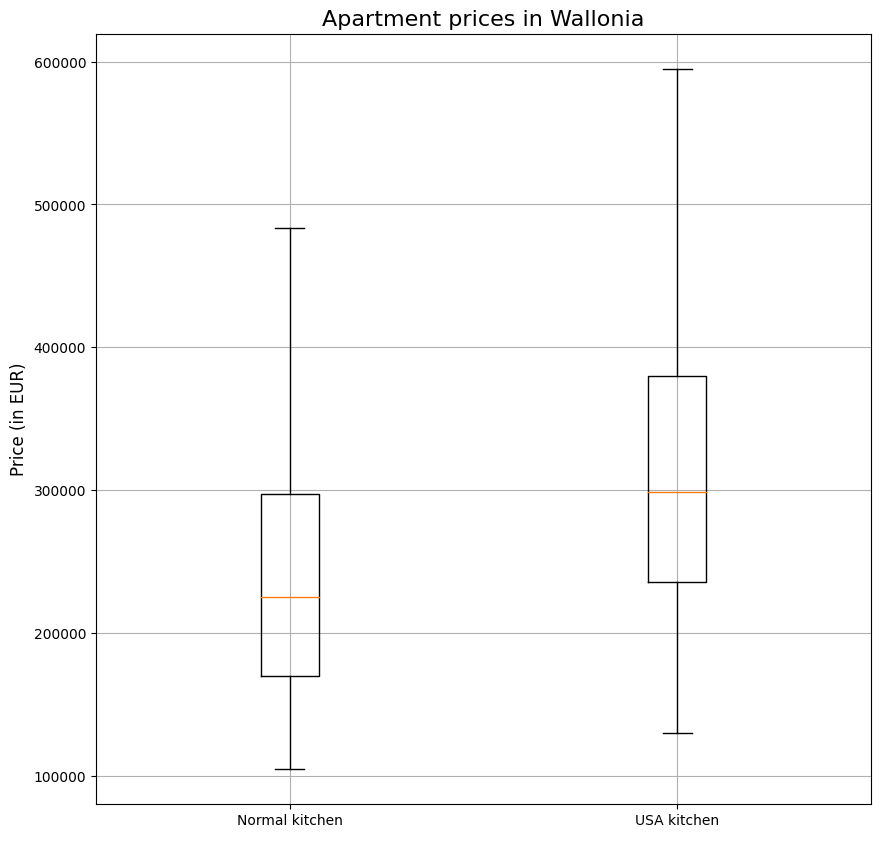

In [811]:
# mean_app= df_app.Price.mean()
# mean_usa= df_usa.Price.mean()

plt.figure(figsize=(10, 10))
plt.boxplot([df_app['Price'], df_usa['Price']],showfliers=False,labels=["Normal kitchen","USA kitchen"])
plt.xlabel(' ', fontsize=15)
plt.ylabel('Price (in EUR)', fontsize=12)
plt.title('Apartment prices in Wallonia', fontsize=16)
plt.grid(True)


It seems like there's a difference in the price according to the kitchen type. We could apply a statistical test in a next phase to see the significant difference. 

### Case 2: Analyzing the price difference between several properties in the provinces of Flanders according to their state. 

In [812]:
df_Flanders=df[df.Region=="Flanders"]

#Select apartments and houses
df_Flanders=df_Flanders[df_Flanders.Type_of_property.isin([1,3])]

#drop the columns with empty values for state of building
df_Flanders.dropna(subset=['State_of_the_building'], inplace=True)



We will use a histogram to plot the differences: 

C:\Users\nacit\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


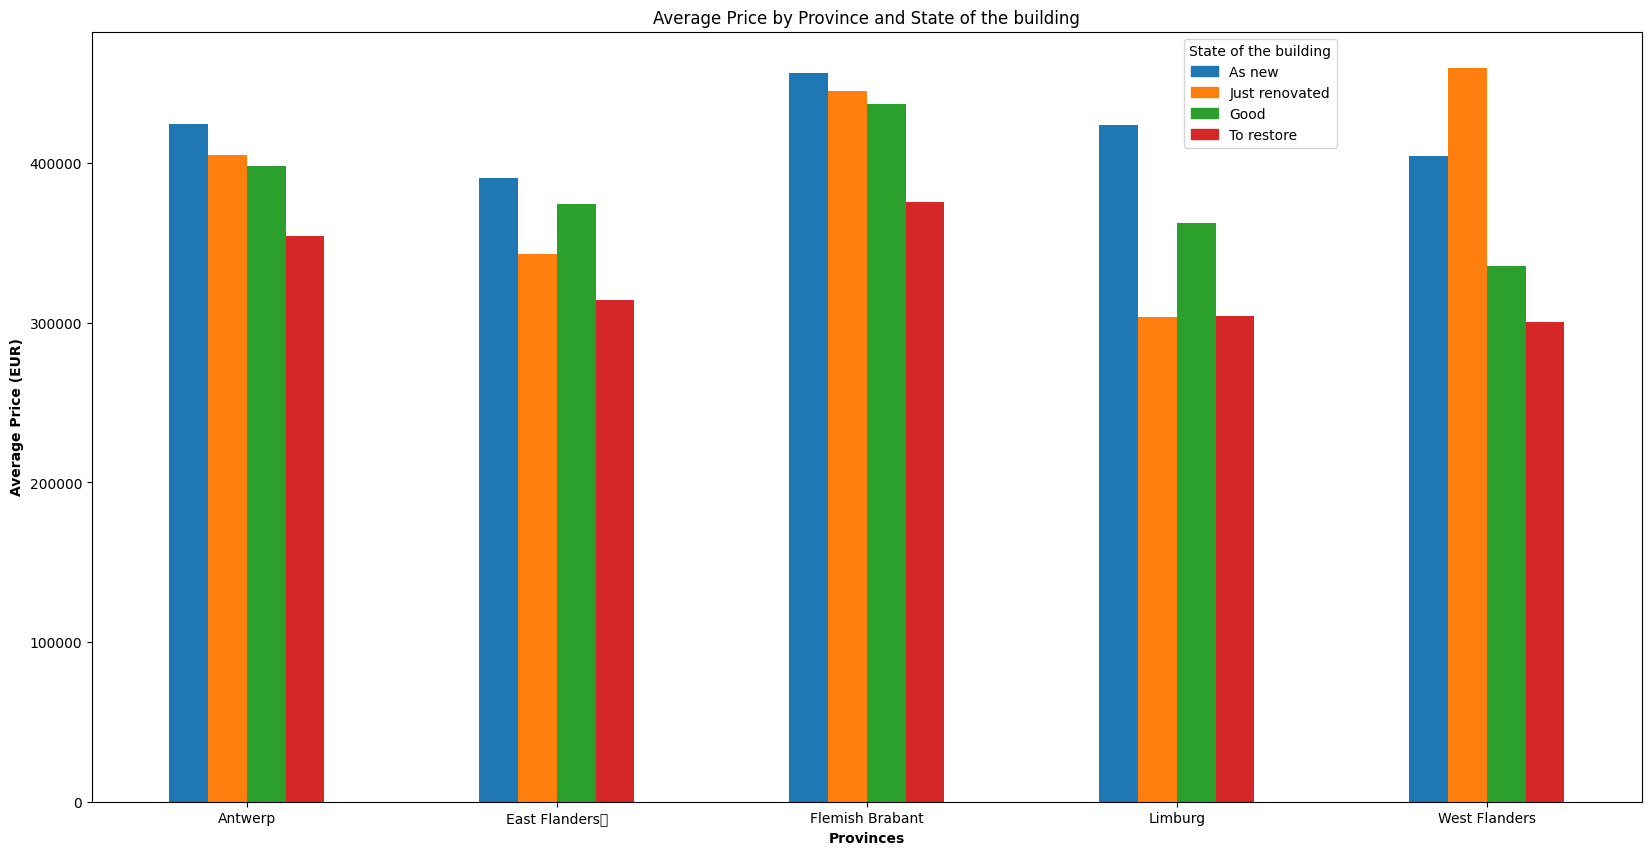

In [813]:

import matplotlib.patches as mpatches

plt.rcParams['figure.figsize'] = [20, 10]
df_Flanders_province = df_Flanders[['Price','Province','State_of_the_building']]
grouped_data = df_Flanders_province.groupby(['Province','State_of_the_building']).mean()
grouped_data = grouped_data.unstack()
grouped_data.plot(kind='bar', rot=0)
plt.xlabel('Provinces', fontdict={'weight':'bold'})
plt.ylabel('Average Price (EUR)',fontdict={'weight':'bold'})
plt.title('Average Price by Province and State of the building')
# plt.legend(title='State of the building',loc='upper left', bbox_to_anchor=(1,1))
# plt.show()

# Create custom legend
as_new = mpatches.Patch(color='tab:blue', label='As new')
just_renovated = mpatches.Patch(color='tab:orange', label='Just renovated')
good = mpatches.Patch(color='tab:green', label='Good')
to_restore = mpatches.Patch(color='tab:red', label='To restore')

# Add custom legend to the plot
plt.legend(handles=[as_new, just_renovated, good, to_restore], bbox_to_anchor=(0.70, 1), title='State of the building')

# Show plot
plt.show()

After comparing the price from new properties and properties to restore (in each province), we see that in Limburg and West Flanders there's a good profit margin. 